In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, SimpleRNN, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

Data preprocessing

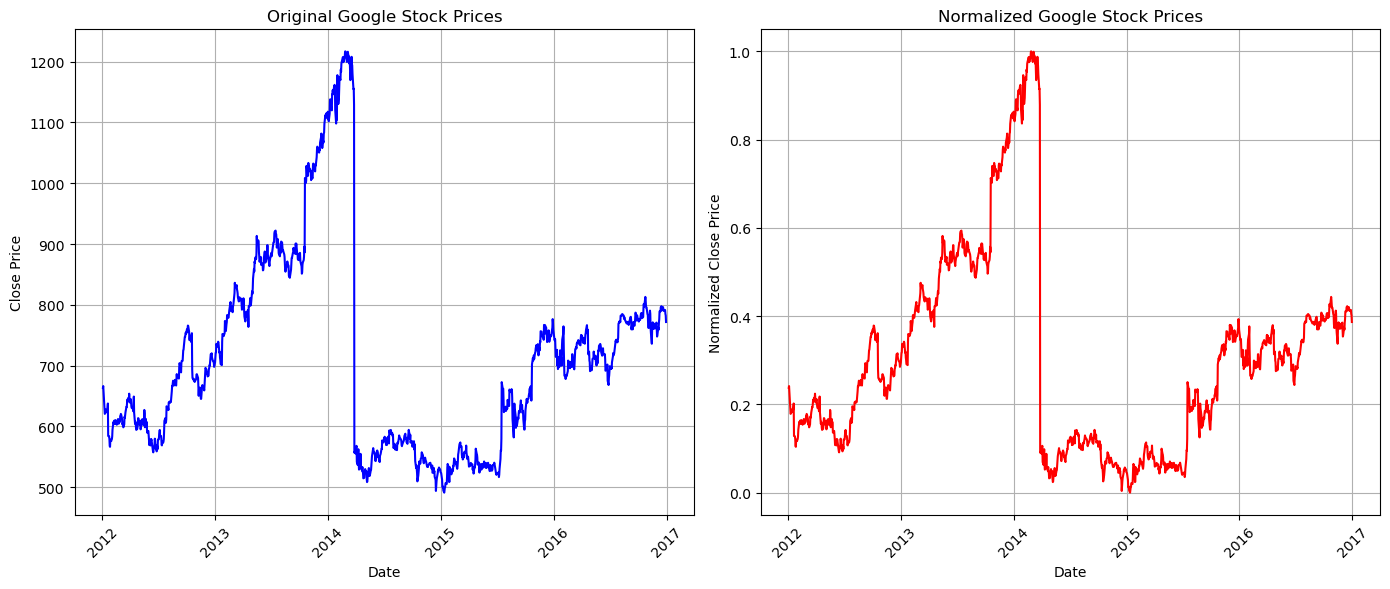

In [12]:
##加载数据
train_data = pd.read_csv('/Users/oliviagarbo/Documents/Deep learning/assignment 3/Google_Stock_Price_Train.csv')
test_data = pd.read_csv('/Users/oliviagarbo/Documents/Deep learning/assignment 3/Google_Stock_Price_Test.csv')

# 清理数据
# 确保 'Close' 列为字符串类型后再进行替换
if train_data['Close'].dtype == 'object':
    train_data['Close'] = train_data['Close'].str.replace(',', '').astype(float)
if test_data['Close'].dtype == 'object':
    test_data['Close'] = test_data['Close'].str.replace(',', '').astype(float)


# Extract the 'Close' column and normalize
scaler = MinMaxScaler()
train_close = train_data['Close'].values.reshape(-1, 1)
test_close = test_data['Close'].values.reshape(-1, 1)
train_close_scaled = scaler.fit_transform(train_close)
test_close_scaled = scaler.transform(test_close)


# 确保 'Date' 列为日期格式
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

# 可视化原始数据和标准化后的数据
plt.figure(figsize=(14, 6))

# 原始数据
plt.subplot(1, 2, 1)
plt.plot(train_data['Date'], train_data['Close'], color='blue', label='Original Data')
plt.title('Original Google Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')

# 设置横轴为年份间隔（与右边图一致）
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # 每年显示一个标签
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # 设置日期格式为年份
plt.xticks(rotation=45)  # 旋转横轴日期标签45度
plt.grid(True)

# 标准化后的数据
plt.subplot(1, 2, 2)
plt.plot(train_data['Date'], train_close_scaled, color='red', label='Normalized Data')
plt.title('Normalized Google Stock Prices')
plt.xlabel('Date')
plt.ylabel('Normalized Close Price')

# 设置横轴为年份间隔（与左边图一致）
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # 每年显示一个标签
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # 设置日期格式为年份
plt.xticks(rotation=45)  # 旋转横轴日期标签45度
plt.grid(True)

# 自动调整布局
plt.tight_layout()
plt.show()


Split training data into training and validation sets

In [13]:
train_close_split, val_close_split = train_test_split(train_close_scaled, test_size=0.2, shuffle=False)

# 创建序列数据
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

n_steps = 30  # 使用过去30天的数据
X, y = create_sequences(train_close_scaled, n_steps)

# Create training and validation sequences
X_train, y_train = create_sequences(train_close_split, n_steps)
X_val, y_val = create_sequences(val_close_split, n_steps)

# Create test sequences
X_test, y_test = create_sequences(test_close_scaled, n_steps)

Vanilla RNN

In [14]:
# 定义 Vanilla RNN 模型
model = Sequential([
    SimpleRNN(50, activation='tanh', return_sequences=False, input_shape=(n_steps, 1)),
    Dense(1)  # 输出单值（下一天的价格）
])

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model training

In [15]:
# 训练模型
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  # 训练轮次
    batch_size=32,
    verbose=1
)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0357 - val_loss: 0.0018
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 4.7486e-04
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 1.7935e-04
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 1.7688e-04
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - val_loss: 1.7618e-04
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8452e-04 - val_loss: 1.7004e-04
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4549e-04 - val_loss: 1.4824e-04
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 - val_loss: 2.2300e-04
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 1.6800e-04
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 2.3805e-04
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 1.7657e-04
Epoch 12/20
31/31 ━━━━━━━━

Evaluation and prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from current font.
  fig.canvas.print_figure(b

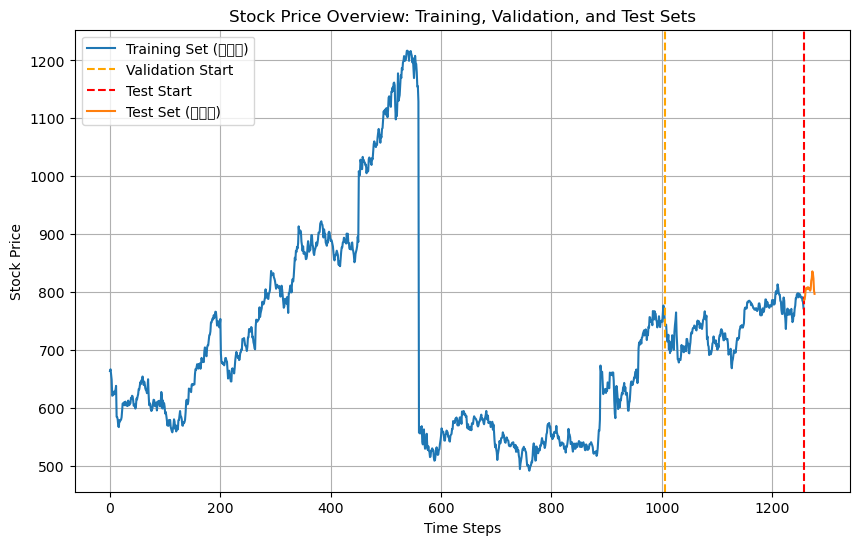

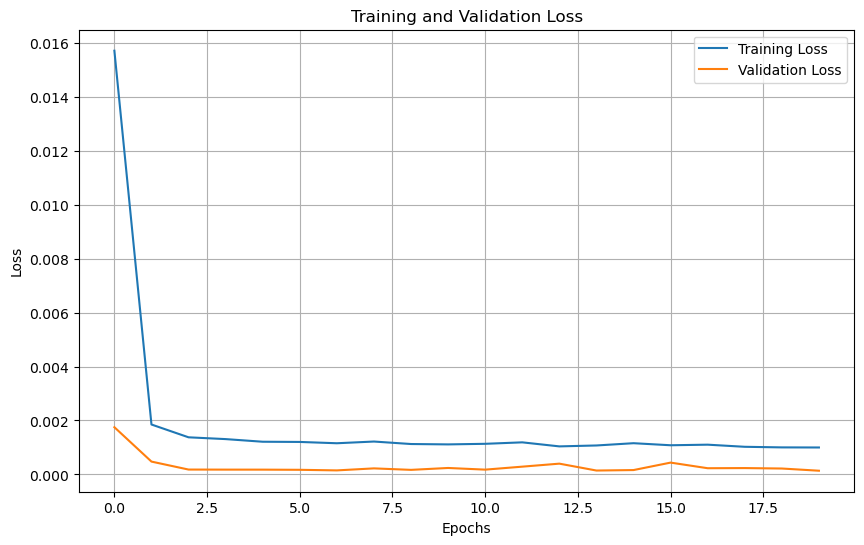

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(b

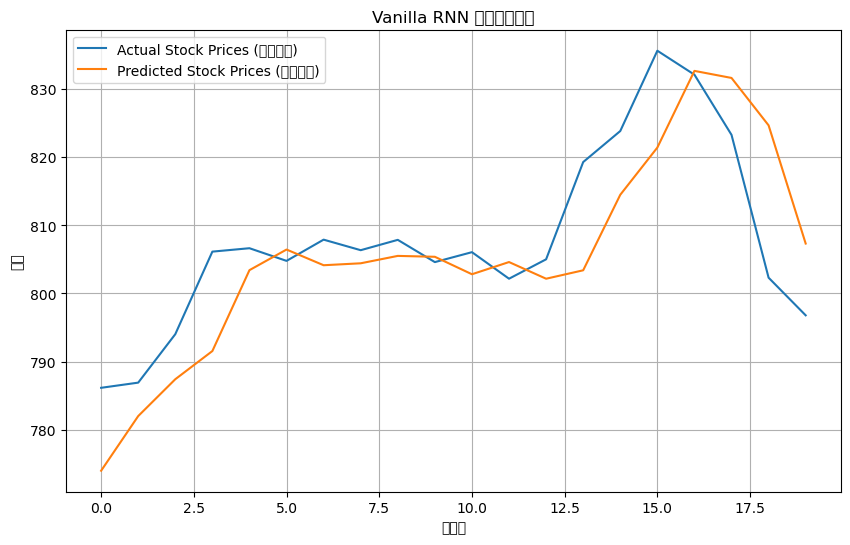

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


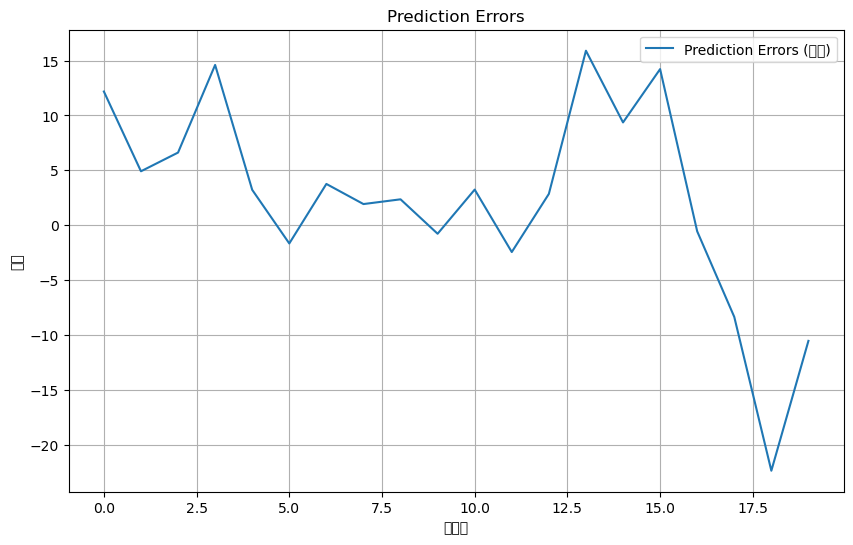

MSE: 85.8591, MAE: 7.0963


In [16]:
# 调整测试数据并生成序列（保证长度足够）
if len(test_close_scaled) <= n_steps:
    test_close_combined = np.concatenate((train_close_scaled[-n_steps:], test_close_scaled), axis=0)
else:
    test_close_combined = test_close_scaled
X_test, y_test = create_sequences(test_close_combined, n_steps)

# 模型预测
predictions = model.predict(X_test)

# 反归一化
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 可视化结果

plt.figure(figsize=(10, 6))
plt.plot(train_data['Close'], label='Training Set (训练集)')
plt.axvline(x=len(train_data) - len(val_close_split), color='orange', linestyle='--', label='Validation Start')
plt.axvline(x=len(train_data), color='red', linestyle='--', label='Test Start')
plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), test_data['Close'], label='Test Set (测试集)')
plt.title('Stock Price Overview: Training, Validation, and Test Sets')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

# 2. 训练和验证损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 3. 真实值与预测值的对比
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Stock Prices (真实价格)')
plt.plot(predictions, label='Predicted Stock Prices (预测价格)')
plt.legend()
plt.title('Vanilla RNN 股票价格预测')
plt.xlabel('时间步')
plt.ylabel('价格')
plt.grid()
plt.show()

# 4. 预测误差（真实值 - 预测值）
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.plot(errors, label='Prediction Errors (误差)')
plt.title('Prediction Errors')
plt.xlabel('时间步')
plt.ylabel('误差')
plt.legend()
plt.grid()
plt.show()

# 评估模型性能
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

Vanilla RNN improved

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1114 - val_loss: 0.0031
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 4.1297e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 3.9373e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - val_loss: 4.4090e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - val_loss: 4.4858e-04
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - val_loss: 4.8684e-04
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - val_loss: 3.9012e-04
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - val_loss: 3.0363e-04
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 4.0641e-04
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - val_loss: 7.2503e-04
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from current font.
  fig.canvas.print_figure(b

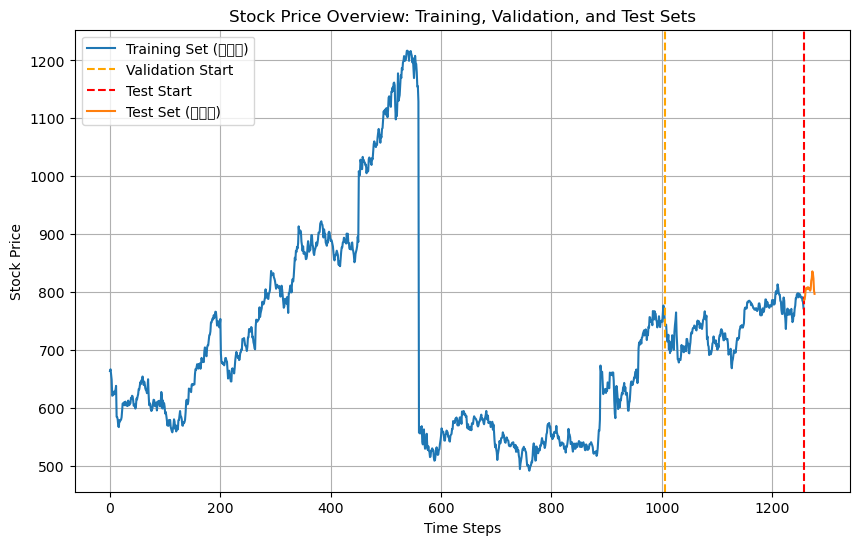

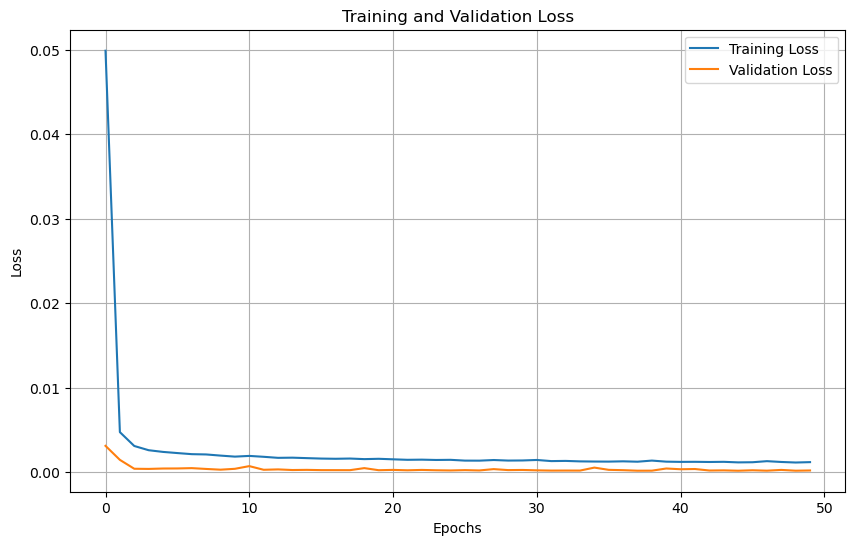

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(b

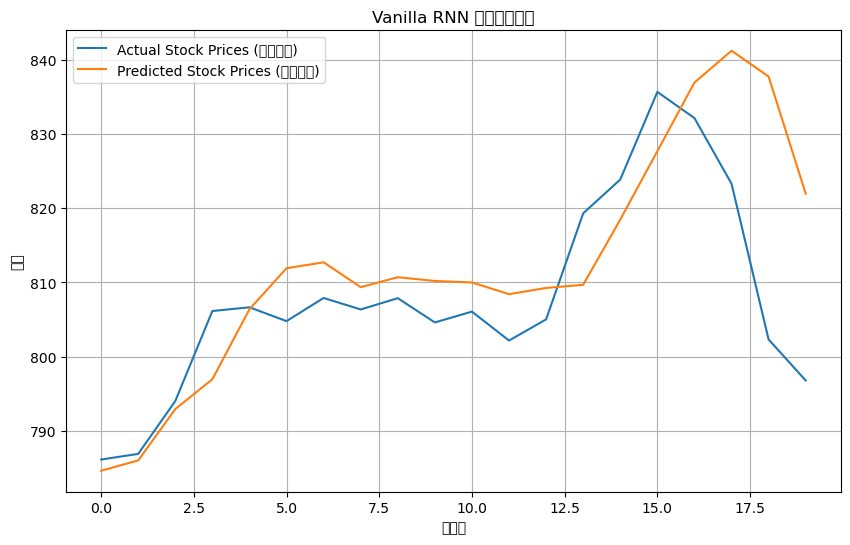

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


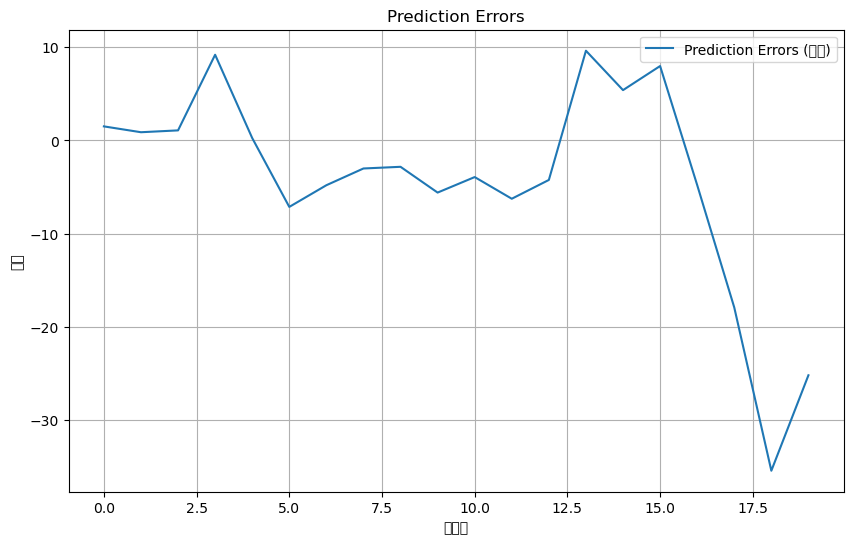

MSE: 135.0694, MAE: 7.8495


In [17]:
# 定义 Vanilla RNN 模型
model = Sequential([
    SimpleRNN(50, activation='tanh', return_sequences=False, input_shape=(n_steps, 1)),
    Dense(1)  # 输出单值（下一天的价格）
])

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # 增加训练轮数
    batch_size=64,
    verbose=1
)
# 调整测试数据并生成序列（保证长度足够）
if len(test_close_scaled) <= n_steps:
    test_close_combined = np.concatenate((train_close_scaled[-n_steps:], test_close_scaled), axis=0)
else:
    test_close_combined = test_close_scaled
X_test, y_test = create_sequences(test_close_combined, n_steps)

# 模型预测
predictions = model.predict(X_test)

# 反归一化
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 可视化结果

plt.figure(figsize=(10, 6))
plt.plot(train_data['Close'], label='Training Set (训练集)')
plt.axvline(x=len(train_data) - len(val_close_split), color='orange', linestyle='--', label='Validation Start')
plt.axvline(x=len(train_data), color='red', linestyle='--', label='Test Start')
plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), test_data['Close'], label='Test Set (测试集)')
plt.title('Stock Price Overview: Training, Validation, and Test Sets')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

# 2. 训练和验证损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 3. 真实值与预测值的对比
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Stock Prices (真实价格)')
plt.plot(predictions, label='Predicted Stock Prices (预测价格)')
plt.legend()
plt.title('Vanilla RNN 股票价格预测')
plt.xlabel('时间步')
plt.ylabel('价格')
plt.grid()
plt.show()

# 4. 预测误差（真实值 - 预测值）
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.plot(errors, label='Prediction Errors (误差)')
plt.title('Prediction Errors')
plt.xlabel('时间步')
plt.ylabel('误差')
plt.legend()
plt.grid()
plt.show()


# 评估模型性能
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

Vanilla RNN improved 2

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0762 - val_loss: 0.0056
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0075 - val_loss: 6.3289e-04
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - val_loss: 3.5297e-04
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - val_loss: 8.5448e-04
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 3.6083e-04
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - val_loss: 4.1729e-04
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - val_loss: 2.8209e-04
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 3.3634e-04
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 2.9501e-04
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0022 - val_loss: 3.0539e-04
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from current font.
  fig.canvas.print_figure(b

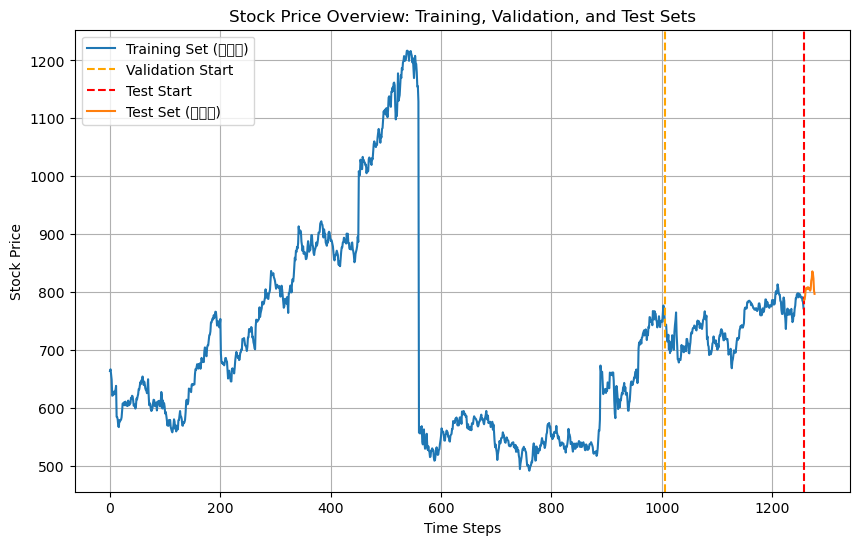

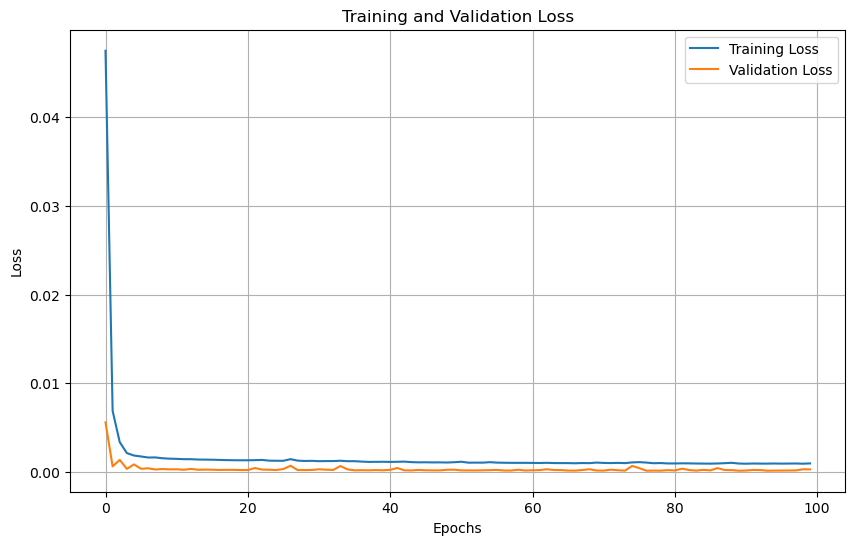

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(b

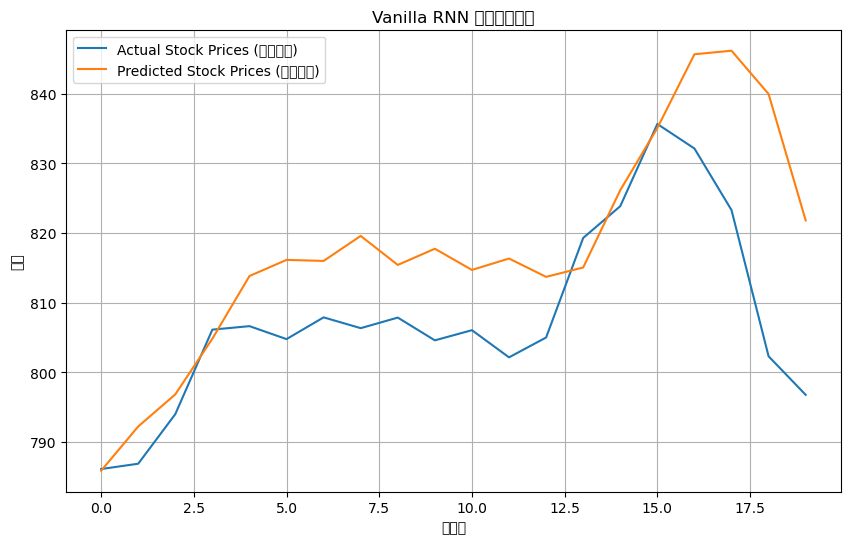

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


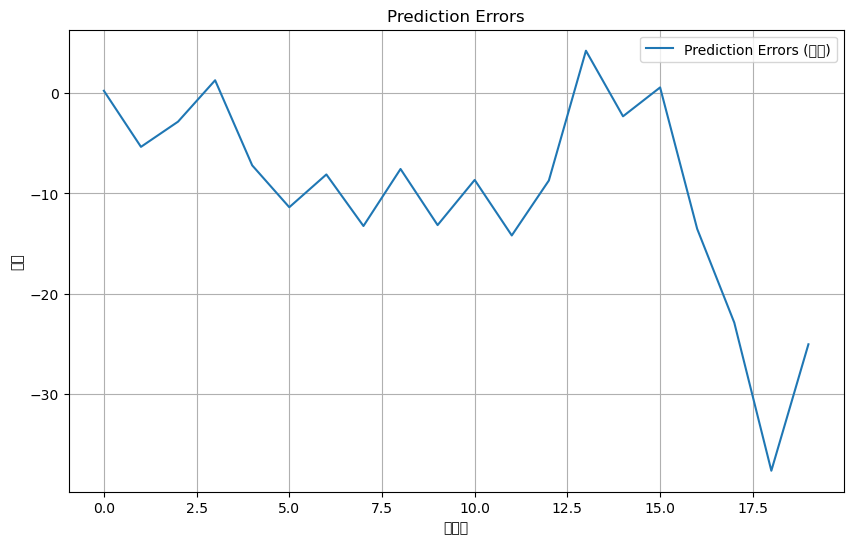

MSE: 190.8601, MAE: 10.4051


In [18]:
# 定义 Vanilla RNN 模型
model = Sequential([
    SimpleRNN(50, activation='tanh', return_sequences=False, input_shape=(n_steps, 1)),
    Dense(1)  # 输出单值（下一天的价格）
])

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # 增加训练轮数
    batch_size=128,
    verbose=1
)

# 调整测试数据并生成序列（保证长度足够）
if len(test_close_scaled) <= n_steps:
    test_close_combined = np.concatenate((train_close_scaled[-n_steps:], test_close_scaled), axis=0)
else:
    test_close_combined = test_close_scaled
X_test, y_test = create_sequences(test_close_combined, n_steps)

# 模型预测
predictions = model.predict(X_test)

# 反归一化
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 可视化结果

plt.figure(figsize=(10, 6))
plt.plot(train_data['Close'], label='Training Set (训练集)')
plt.axvline(x=len(train_data) - len(val_close_split), color='orange', linestyle='--', label='Validation Start')
plt.axvline(x=len(train_data), color='red', linestyle='--', label='Test Start')
plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), test_data['Close'], label='Test Set (测试集)')
plt.title('Stock Price Overview: Training, Validation, and Test Sets')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

# 2. 训练和验证损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 3. 真实值与预测值的对比
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Stock Prices (真实价格)')
plt.plot(predictions, label='Predicted Stock Prices (预测价格)')
plt.legend()
plt.title('Vanilla RNN 股票价格预测')
plt.xlabel('时间步')
plt.ylabel('价格')
plt.grid()
plt.show()

# 4. 预测误差（真实值 - 预测值）
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.plot(errors, label='Prediction Errors (误差)')
plt.title('Prediction Errors')
plt.xlabel('时间步')
plt.ylabel('误差')
plt.legend()
plt.grid()
plt.show()


# 评估模型性能
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

Vanilla RNNimproved 2 regu

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.1605 - val_loss: 0.8103
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7888 - val_loss: 0.7236
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7226 - val_loss: 0.6753
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6651 - val_loss: 0.6194
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6145 - val_loss: 0.5772
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5717 - val_loss: 0.5360
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5299 - val_loss: 0.4989
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4944 - val_loss: 0.4642
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4583 - val_loss: 0.4322
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4280 - val_loss: 0.4026
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3986 - val_loss: 0.3751
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3709 - val_loss: 0.3498


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from current font.
  fig.canvas.print_figure(b

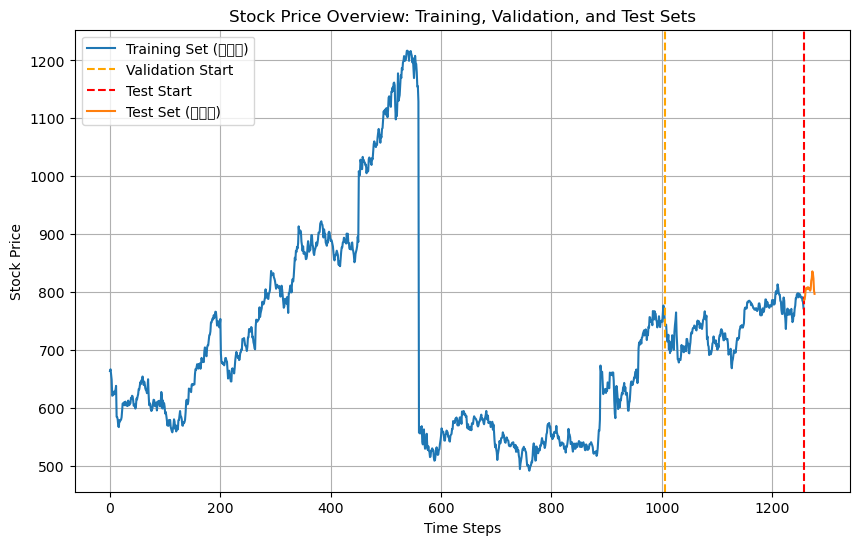

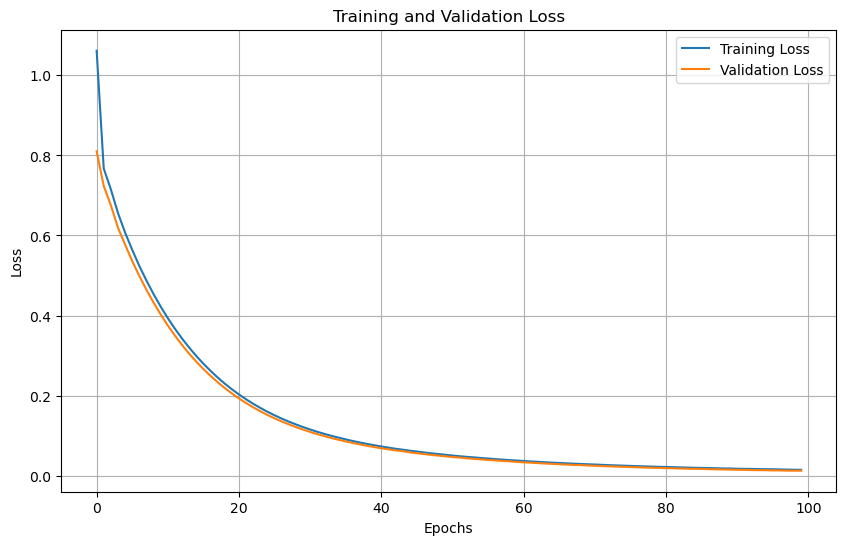

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(b

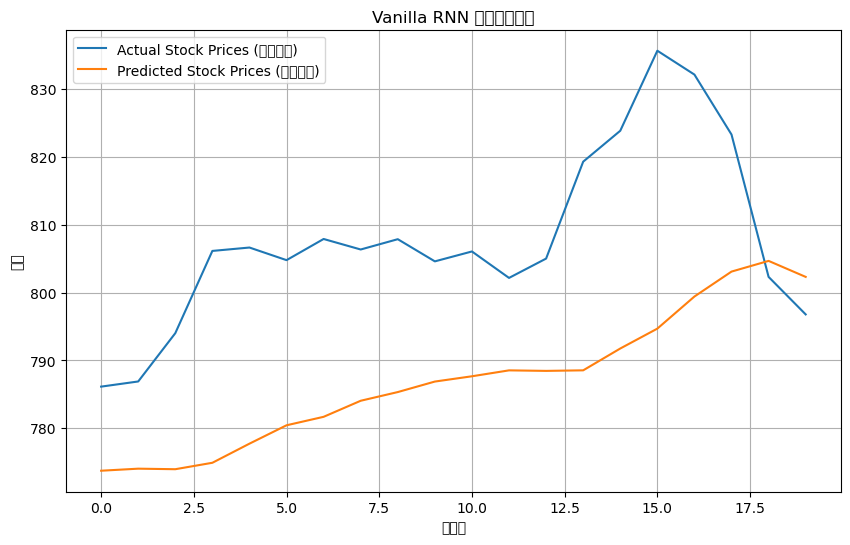

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


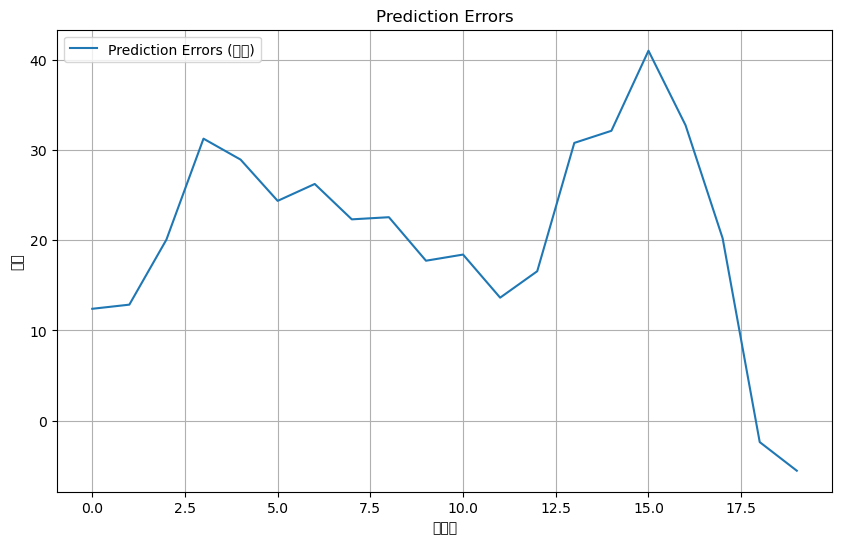

MSE: 555.2268, MAE: 21.5942


In [19]:
# 定义 Vanilla RNN 模型
model = Sequential()
 # 添加 L2 正则化的层
model.add(Dense(64, input_dim=30, activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))  # 0.01是L2正则化的强度

model.add(Dense(32, activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))

model.add(Dense(1, activation='linear'))

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # 增加训练轮数
    batch_size=128,
    verbose=1
)

# 调整测试数据并生成序列（保证长度足够）
if len(test_close_scaled) <= n_steps:
    test_close_combined = np.concatenate((train_close_scaled[-n_steps:], test_close_scaled), axis=0)
else:
    test_close_combined = test_close_scaled
X_test, y_test = create_sequences(test_close_combined, n_steps)

# 模型预测
predictions = model.predict(X_test)

# 反归一化
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 可视化结果

plt.figure(figsize=(10, 6))
plt.plot(train_data['Close'], label='Training Set (训练集)')
plt.axvline(x=len(train_data) - len(val_close_split), color='orange', linestyle='--', label='Validation Start')
plt.axvline(x=len(train_data), color='red', linestyle='--', label='Test Start')
plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), test_data['Close'], label='Test Set (测试集)')
plt.title('Stock Price Overview: Training, Validation, and Test Sets')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

# 2. 训练和验证损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 3. 真实值与预测值的对比
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Stock Prices (真实价格)')
plt.plot(predictions, label='Predicted Stock Prices (预测价格)')
plt.legend()
plt.title('Vanilla RNN 股票价格预测')
plt.xlabel('时间步')
plt.ylabel('价格')
plt.grid()
plt.show()

# 4. 预测误差（真实值 - 预测值）
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.plot(errors, label='Prediction Errors (误差)')
plt.title('Prediction Errors')
plt.xlabel('时间步')
plt.ylabel('误差')
plt.legend()
plt.grid()
plt.show()


# 评估模型性能
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

Vanilla RNN improved 3regu

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.8511 - val_loss: 0.8132
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8160 - val_loss: 0.7791
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7801 - val_loss: 0.7477
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7455 - val_loss: 0.7170
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7150 - val_loss: 0.6859
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6853 - val_loss: 0.6563
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6539 - val_loss: 0.6274
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6246 - val_loss: 0.5994
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5971 - val_loss: 0.5723
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5695 - val_loss: 0.5462
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5438 - val_loss: 0.5210
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5188 - val_loss: 0.4968


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from current font.
  fig.canvas.print_figure(b

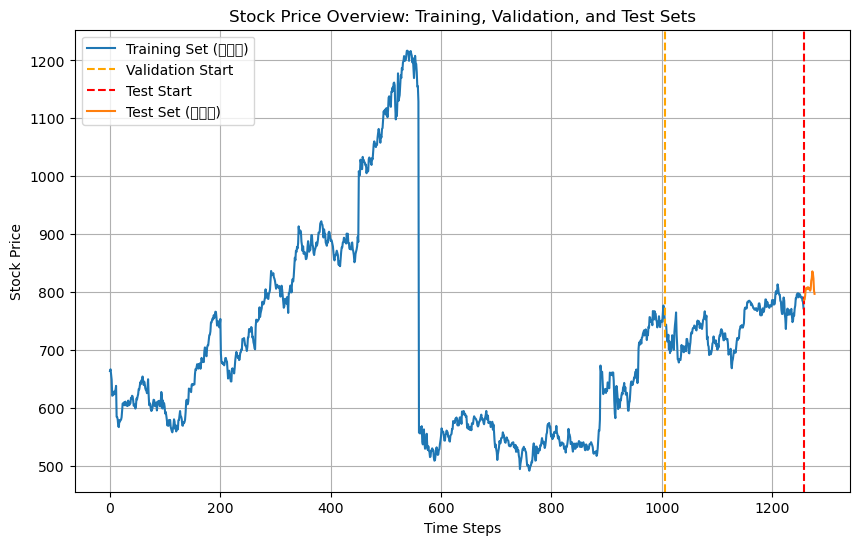

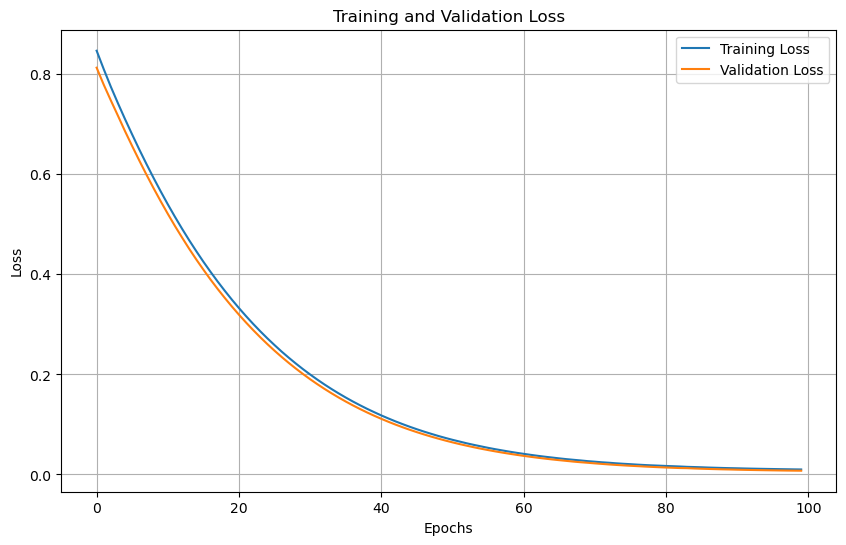

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(b

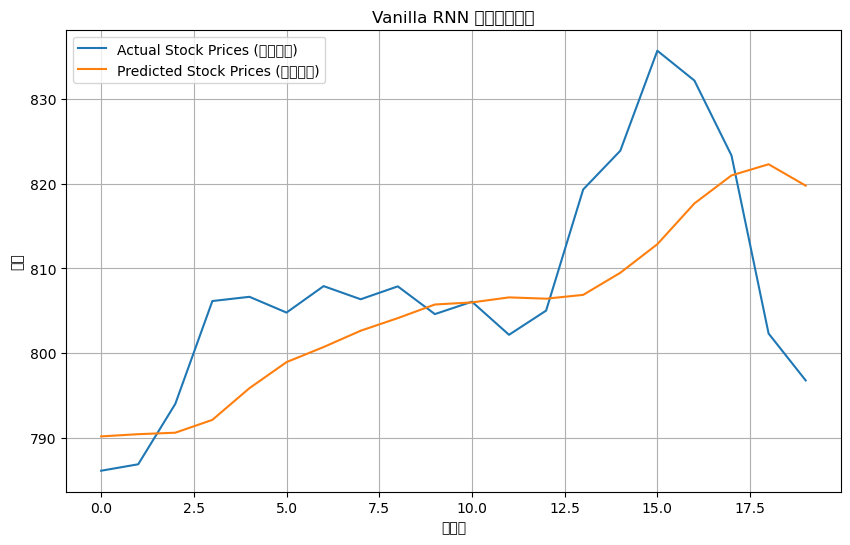

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


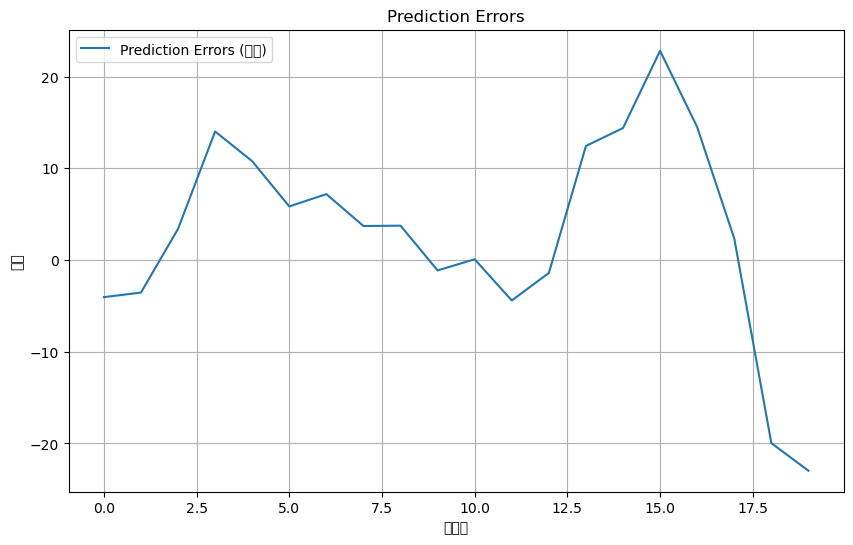

MSE: 125.6372, MAE: 8.6346


In [20]:
# 定义 Vanilla RNN 模型
model = Sequential()
# 添加 L2 正则化的层
model.add(Dense(64, input_dim=30, activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))  # 0.01是L2正则化的强度

model.add(Dense(32, activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))

model.add(Dense(1, activation='linear'))
# 编译模型
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # 增加训练轮数
    batch_size=256,
    verbose=1
)

# 调整测试数据并生成序列（保证长度足够）
if len(test_close_scaled) <= n_steps:
    test_close_combined = np.concatenate((train_close_scaled[-n_steps:], test_close_scaled), axis=0)
else:
    test_close_combined = test_close_scaled
X_test, y_test = create_sequences(test_close_combined, n_steps)

# 模型预测
predictions = model.predict(X_test)

# 反归一化
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 可视化结果

plt.figure(figsize=(10, 6))
plt.plot(train_data['Close'], label='Training Set (训练集)')
plt.axvline(x=len(train_data) - len(val_close_split), color='orange', linestyle='--', label='Validation Start')
plt.axvline(x=len(train_data), color='red', linestyle='--', label='Test Start')
plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), test_data['Close'], label='Test Set (测试集)')
plt.title('Stock Price Overview: Training, Validation, and Test Sets')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

# 2. 训练和验证损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 3. 真实值与预测值的对比
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Stock Prices (真实价格)')
plt.plot(predictions, label='Predicted Stock Prices (预测价格)')
plt.legend()
plt.title('Vanilla RNN 股票价格预测')
plt.xlabel('时间步')
plt.ylabel('价格')
plt.grid()
plt.show()

# 4. 预测误差（真实值 - 预测值）
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.plot(errors, label='Prediction Errors (误差)')
plt.title('Prediction Errors')
plt.xlabel('时间步')
plt.ylabel('误差')
plt.legend()
plt.grid()
plt.show()


# 评估模型性能
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

LSTM

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0758 - val_loss: 0.0031
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0015
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 9.6671e-04
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 4.7513e-04
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 4.1046e-04
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 4.1853e-04
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - val_loss: 4.2674e-04
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - val_loss: 3.6682e-04
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - val_loss: 3.5890e-04
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - val_loss: 4.5899e-04
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_loss: 5.6910e-04
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━

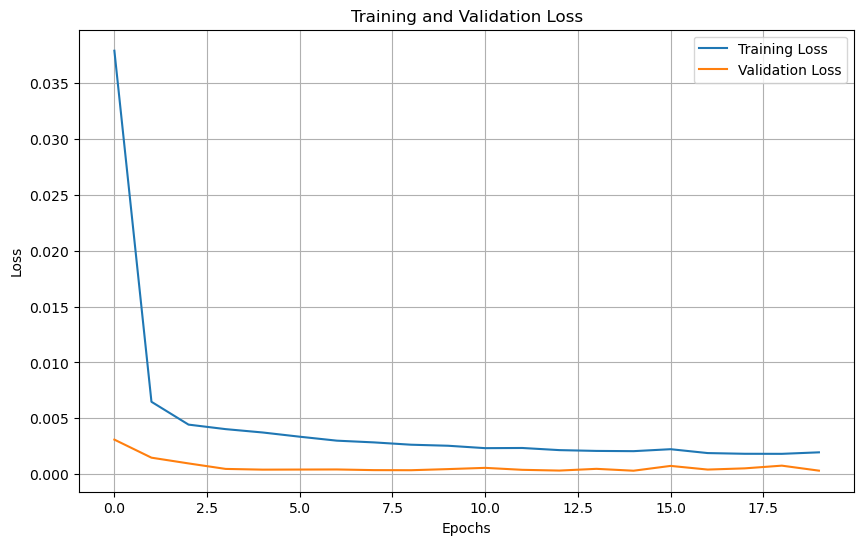

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(b

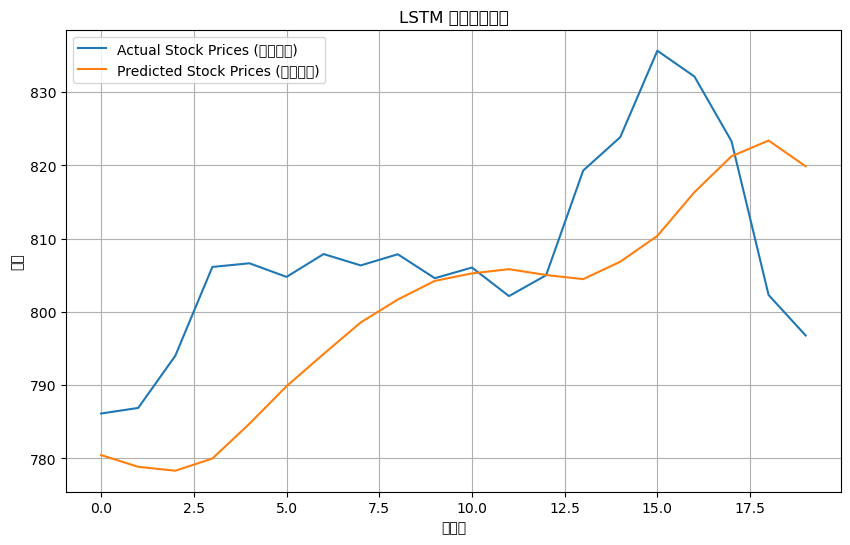

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


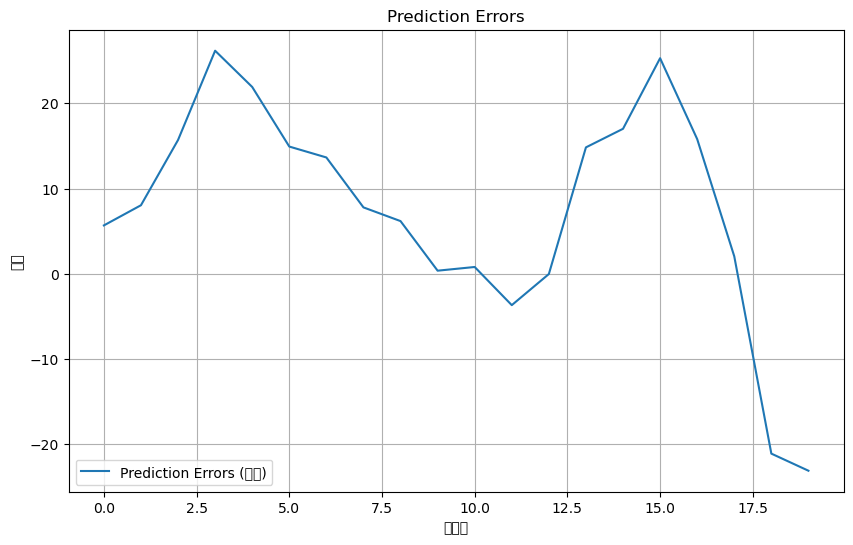

MSE: 220.4418, MAE: 12.2002, RMSE: 14.8473


In [21]:
model = Sequential([
    LSTM(50, activation='tanh', return_sequences=False, input_shape=(n_steps, 1)),
    Dense(1)  # 输出单值（下一天的价格）
])
# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  # 训练轮次
    batch_size=32,
    verbose=1
)
# 调整测试数据并生成序列（如果需要）
if len(test_close_scaled) <= n_steps:
    test_close_combined = np.concatenate((train_close_scaled[-n_steps:], test_close_scaled), axis=0)
else:
    test_close_combined = test_close_scaled
X_test, y_test = create_sequences(test_close_combined, n_steps)

# 模型预测
predictions = model.predict(X_test)

# 反归一化
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 可视化结果

# 1. 训练和验证损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 2. 真实值与预测值的对比
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Stock Prices (真实价格)')
plt.plot(predictions, label='Predicted Stock Prices (预测价格)')
plt.legend()
plt.title('LSTM 股票价格预测')
plt.xlabel('时间步')
plt.ylabel('价格')
plt.grid()
plt.show()

# 3. 预测误差图
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.plot(errors, label='Prediction Errors (误差)')
plt.title('Prediction Errors')
plt.xlabel('时间步')
plt.ylabel('误差')
plt.legend()
plt.grid()
plt.show()

# 评估模型性能
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")


LSTM improved

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0435 - val_loss: 0.0011
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - val_loss: 4.3847e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020 - val_loss: 6.9496e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030 - val_loss: 3.5198e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019 - val_loss: 5.8822e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024 - val_loss: 3.2850e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - val_loss: 3.1861e-04
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015 - val_loss: 4.7402e-04
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019 - val_loss: 7.6760e-04
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - val_loss: 9.1829e-04
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030 - val_loss: 4.0828e-04
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━

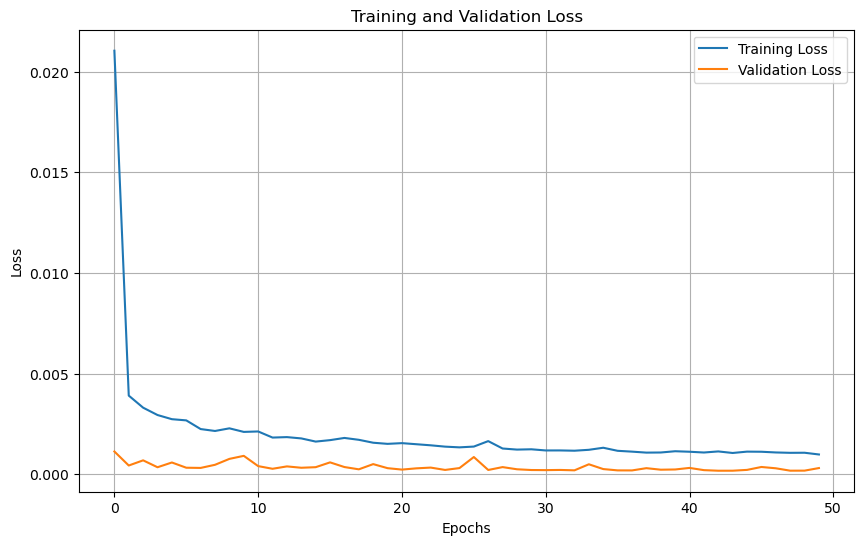

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(b

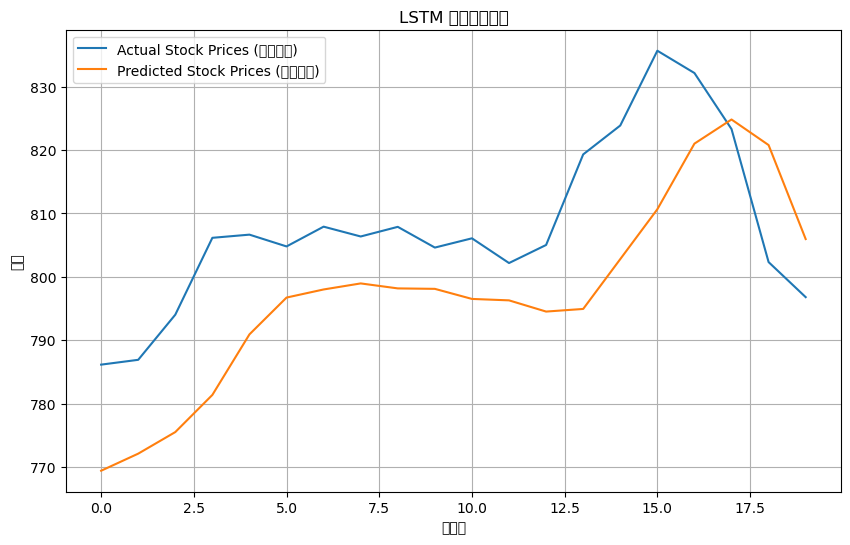

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


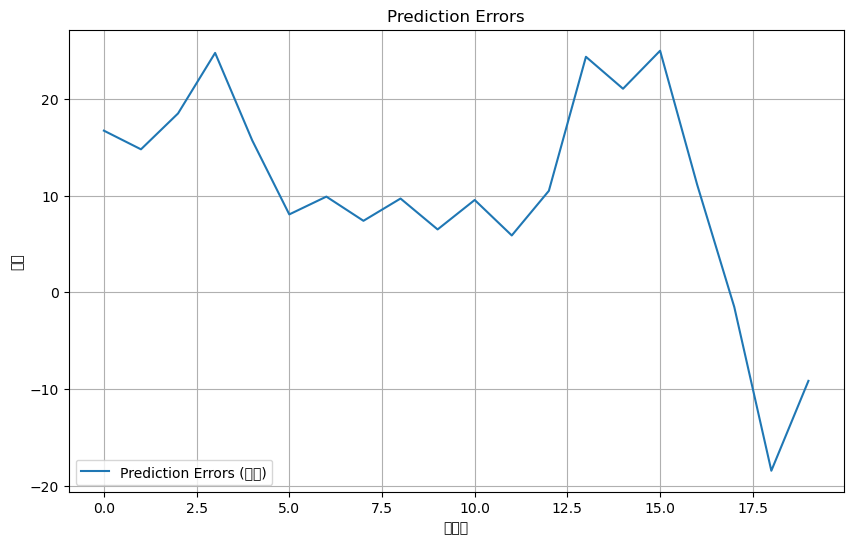

MSE: 225.5787, MAE: 13.4454, RMSE: 15.0193


In [22]:
model = Sequential([
    LSTM(100, activation='tanh', return_sequences=False, input_shape=(n_steps, 1)),
    Dense(1)  # 输出单值（下一天的价格）
])
# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # 增加训练轮数
    batch_size=32,
    verbose=1
)
# 调整测试数据并生成序列（如果需要）
if len(test_close_scaled) <= n_steps:
    test_close_combined = np.concatenate((train_close_scaled[-n_steps:], test_close_scaled), axis=0)
else:
    test_close_combined = test_close_scaled
X_test, y_test = create_sequences(test_close_combined, n_steps)

# 模型预测
predictions = model.predict(X_test)

# 反归一化
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 可视化结果

# 1. 训练和验证损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 2. 真实值与预测值的对比
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Stock Prices (真实价格)')
plt.plot(predictions, label='Predicted Stock Prices (预测价格)')
plt.legend()
plt.title('LSTM 股票价格预测')
plt.xlabel('时间步')
plt.ylabel('价格')
plt.grid()
plt.show()

# 3. 预测误差图
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.plot(errors, label='Prediction Errors (误差)')
plt.title('Prediction Errors')
plt.xlabel('时间步')
plt.ylabel('误差')
plt.legend()
plt.grid()
plt.show()

# 评估模型性能
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")



LSTM improved 2

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0690 - val_loss: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0074 - val_loss: 9.3699e-04
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0046 - val_loss: 6.6774e-04
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037 - val_loss: 5.4447e-04
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0042 - val_loss: 3.9109e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - val_loss: 7.6927e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0033 - val_loss: 3.6717e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0021 - val_loss: 3.9976e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0033 - val_loss: 6.2842e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0034 - val_loss: 6.6379e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034 - val_loss: 8.0283e-04
Epoch 12/100
16/16 ━━━━━

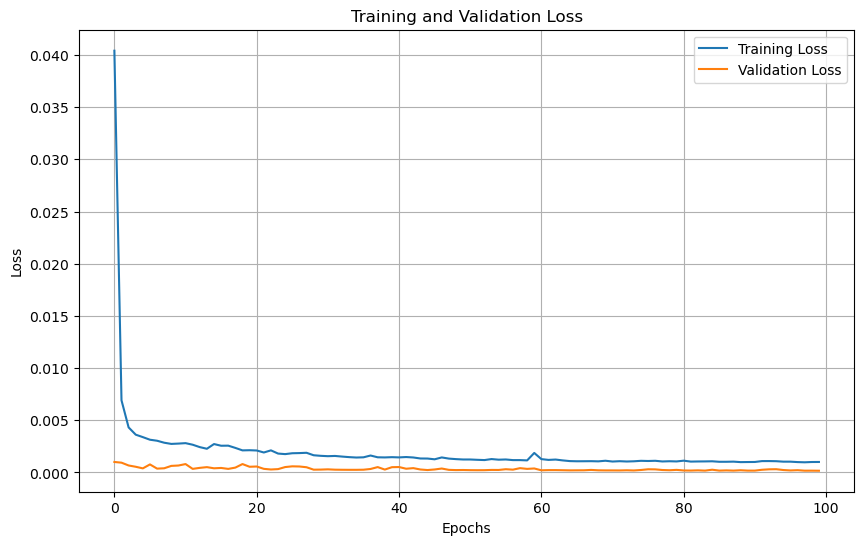

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(b

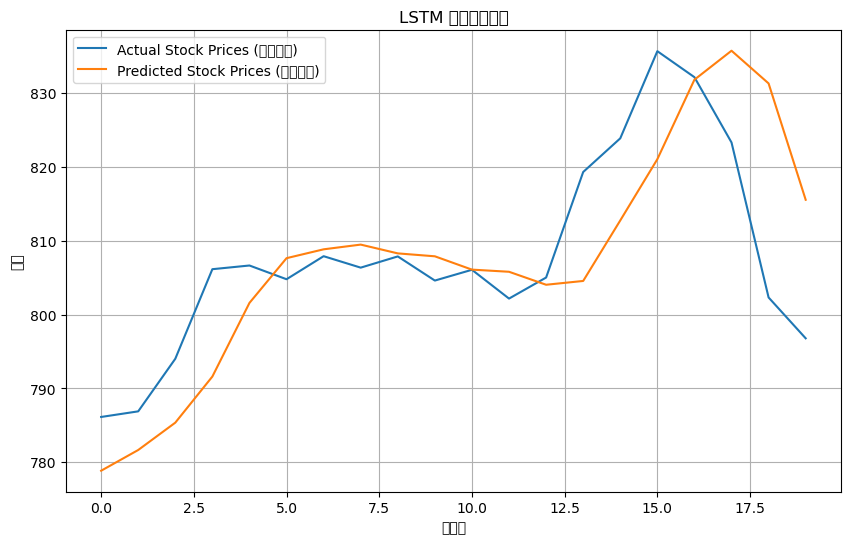

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


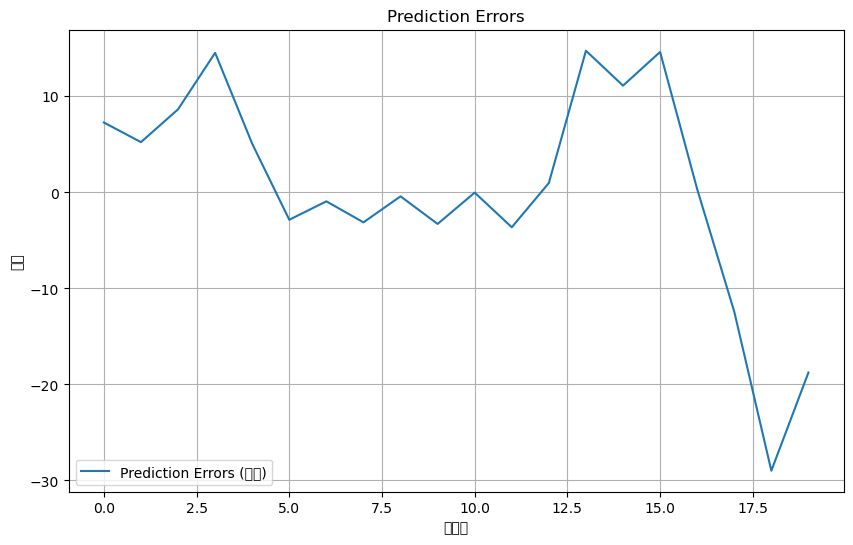

MSE: 116.8816, MAE: 7.8498, RMSE: 10.8112


In [23]:
model = Sequential([
    LSTM(100, activation='tanh', return_sequences=False, input_shape=(n_steps, 1)),
    Dense(1)  # 输出单值（下一天的价格）
])
# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # 增加训练轮数
    batch_size=64,
    verbose=1
)
# 调整测试数据并生成序列（如果需要）
if len(test_close_scaled) <= n_steps:
    test_close_combined = np.concatenate((train_close_scaled[-n_steps:], test_close_scaled), axis=0)
else:
    test_close_combined = test_close_scaled
X_test, y_test = create_sequences(test_close_combined, n_steps)

# 模型预测
predictions = model.predict(X_test)

# 反归一化
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 可视化结果

# 1. 训练和验证损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 2. 真实值与预测值的对比
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Stock Prices (真实价格)')
plt.plot(predictions, label='Predicted Stock Prices (预测价格)')
plt.legend()
plt.title('LSTM 股票价格预测')
plt.xlabel('时间步')
plt.ylabel('价格')
plt.grid()
plt.show()

# 3. 预测误差图
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.plot(errors, label='Prediction Errors (误差)')
plt.title('Prediction Errors')
plt.xlabel('时间步')
plt.ylabel('误差')
plt.legend()
plt.grid()
plt.show()

# 评估模型性能
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")


LSTM improved 3

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0999 - val_loss: 0.0461
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0518 - val_loss: 0.0155
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0208 - val_loss: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0092 - val_loss: 0.0012
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0076 - val_loss: 5.4964e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0069 - val_loss: 6.2077e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0074 - val_loss: 5.2580e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0073 - val_loss: 5.9803e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0081 - val_loss: 5.3698e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0048 - val_loss: 6.0857e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0051 - val_loss: 7.2368e-04
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━

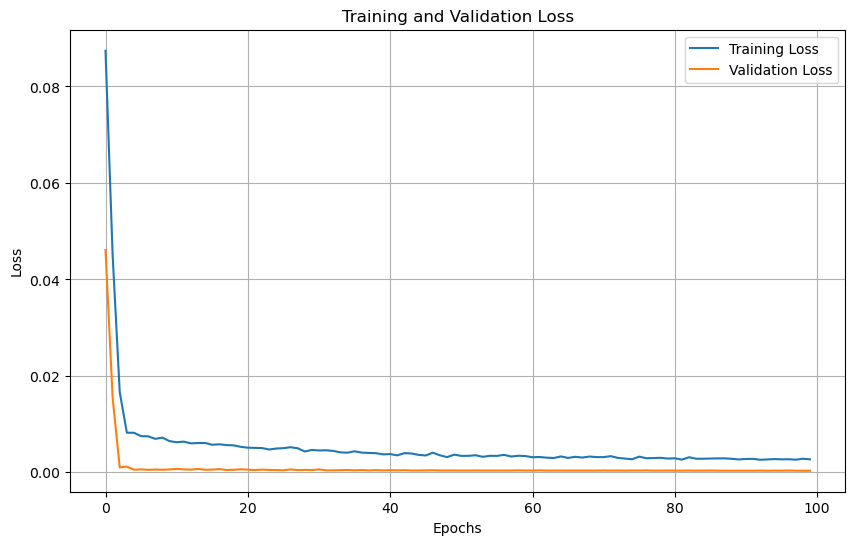

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(b

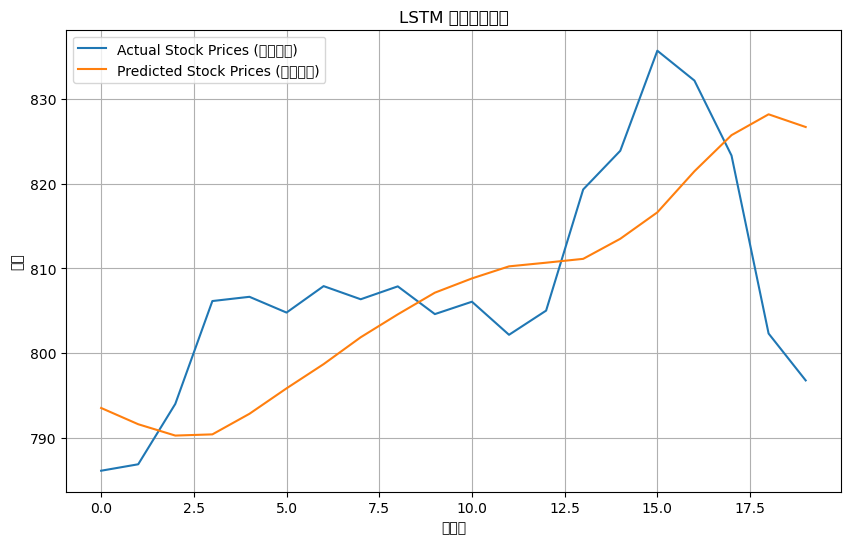

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


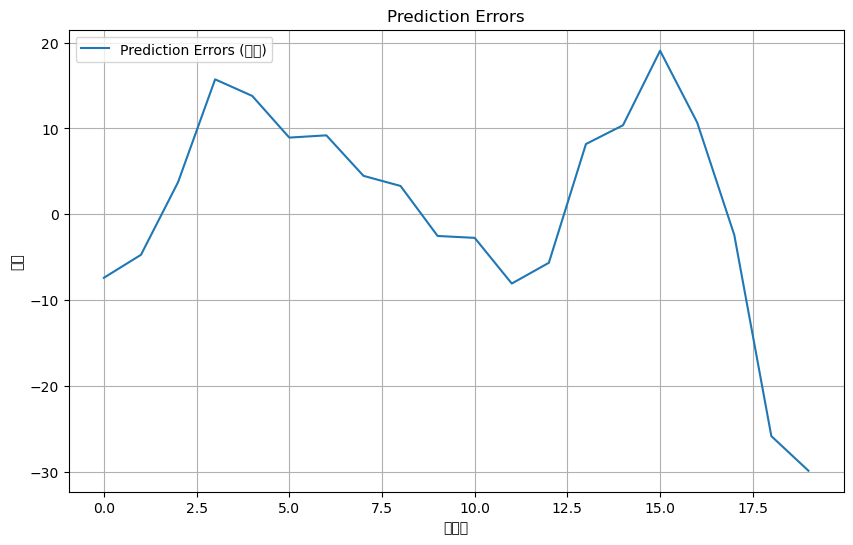

MSE: 152.7241, MAE: 9.8374, RMSE: 12.3582


In [24]:
model = Sequential([
    LSTM(100, activation='tanh', return_sequences=False, input_shape=(n_steps, 1)),
    Dropout(0.2), 
    Dense(1)  # 输出单值（下一天的价格）
])
# 编译模型
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')  
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # 增加训练轮数
    batch_size=64,
    verbose=1
)

# 调整测试数据并生成序列（如果需要）
if len(test_close_scaled) <= n_steps:
    test_close_combined = np.concatenate((train_close_scaled[-n_steps:], test_close_scaled), axis=0)
else:
    test_close_combined = test_close_scaled
X_test, y_test = create_sequences(test_close_combined, n_steps)

# 模型预测
predictions = model.predict(X_test)

# 反归一化
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 可视化结果

# 1. 训练和验证损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 2. 真实值与预测值的对比
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Stock Prices (真实价格)')
plt.plot(predictions, label='Predicted Stock Prices (预测价格)')
plt.legend()
plt.title('LSTM 股票价格预测')
plt.xlabel('时间步')
plt.ylabel('价格')
plt.grid()
plt.show()

# 3. 预测误差图
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.plot(errors, label='Prediction Errors (误差)')
plt.title('Prediction Errors')
plt.xlabel('时间步')
plt.ylabel('误差')
plt.legend()
plt.grid()
plt.show()

# 评估模型性能
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")


LSTM improved regu

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1886 - val_loss: 0.1244
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1437 - val_loss: 0.0872
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0943 - val_loss: 0.0552
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0632 - val_loss: 0.0287
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0363 - val_loss: 0.0183
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0295 - val_loss: 0.0181
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0273 - val_loss: 0.0174
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0259 - val_loss: 0.0169
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0262 - val_loss: 0.0164
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0247 - val_loss: 0.0160
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0212 - val_loss: 0.0156
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

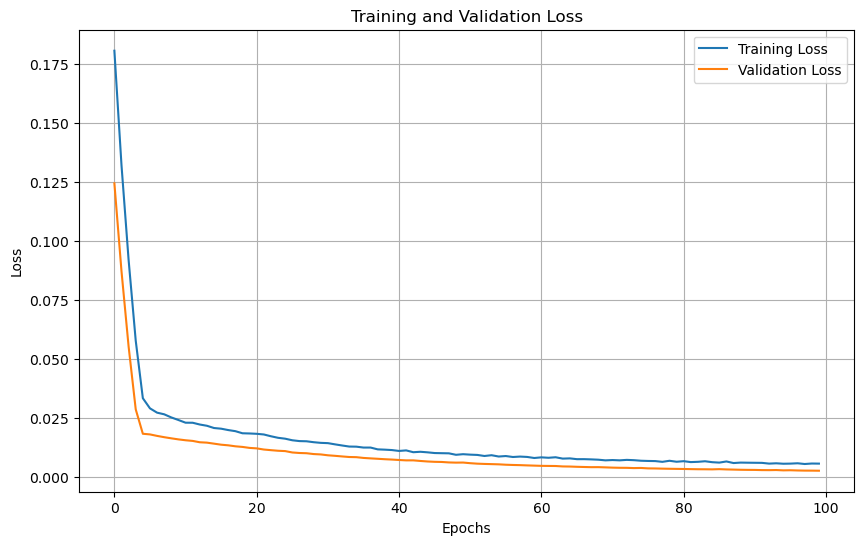

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(b

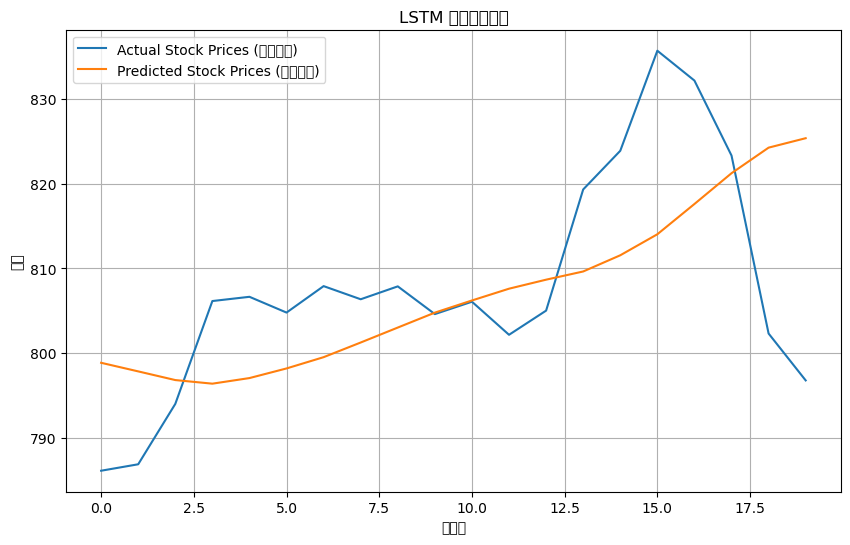

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


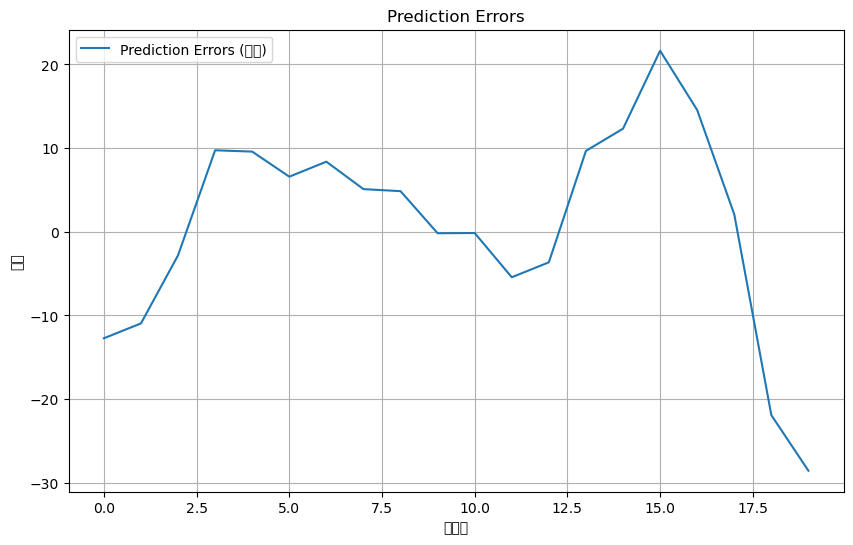

MSE: 145.4632, MAE: 9.5458, RMSE: 12.0608


In [25]:
model = Sequential([
    LSTM(100, activation='tanh', return_sequences=False, 
         kernel_regularizer=l2(0.01), input_shape=(n_steps, 1)),
    Dropout(0.2),
    Dense(1)  # 输出层
])

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')  # 学习率调整为 0.0005
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # 增加训练轮数
    batch_size=64,
    verbose=1
)
# 调整测试数据并生成序列（如果需要）
if len(test_close_scaled) <= n_steps:
    test_close_combined = np.concatenate((train_close_scaled[-n_steps:], test_close_scaled), axis=0)
else:
    test_close_combined = test_close_scaled
X_test, y_test = create_sequences(test_close_combined, n_steps)

# 模型预测
predictions = model.predict(X_test)

# 反归一化
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 可视化结果

# 1. 训练和验证损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 2. 真实值与预测值的对比
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Stock Prices (真实价格)')
plt.plot(predictions, label='Predicted Stock Prices (预测价格)')
plt.legend()
plt.title('LSTM 股票价格预测')
plt.xlabel('时间步')
plt.ylabel('价格')
plt.grid()
plt.show()

# 3. 预测误差图
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.plot(errors, label='Prediction Errors (误差)')
plt.title('Prediction Errors')
plt.xlabel('时间步')
plt.ylabel('误差')
plt.legend()
plt.grid()
plt.show()

# 评估模型性能
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")



LSTM improved multi

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0992 - val_loss: 0.0552
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0680 - val_loss: 0.0290
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0388 - val_loss: 0.0100
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0180 - val_loss: 0.0012
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0089 - val_loss: 0.0018
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0115 - val_loss: 0.0018
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0067 - val_loss: 8.2959e-04
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0071 - val_loss: 7.3407e-04
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0070 - val_loss: 7.8695e-04
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0065 - val_loss: 7.0771e-04
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0069 - val_loss: 6.5637e-04
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - l

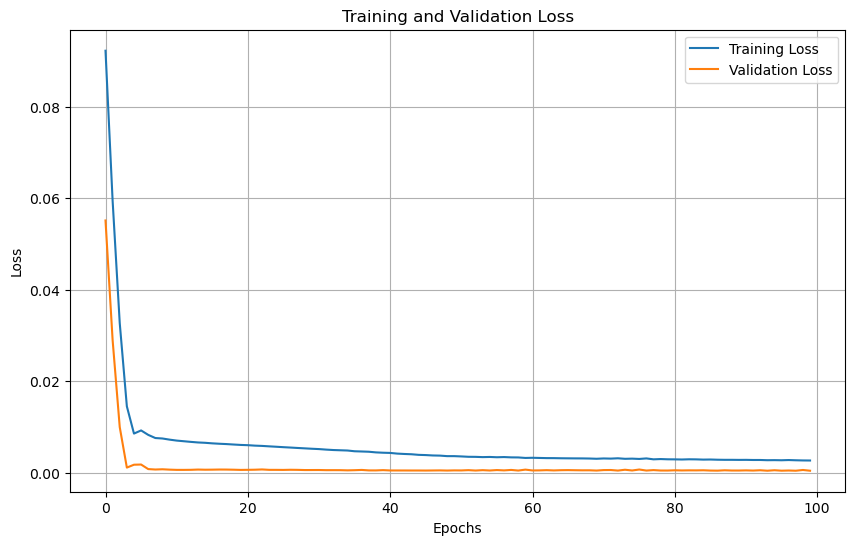

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(b

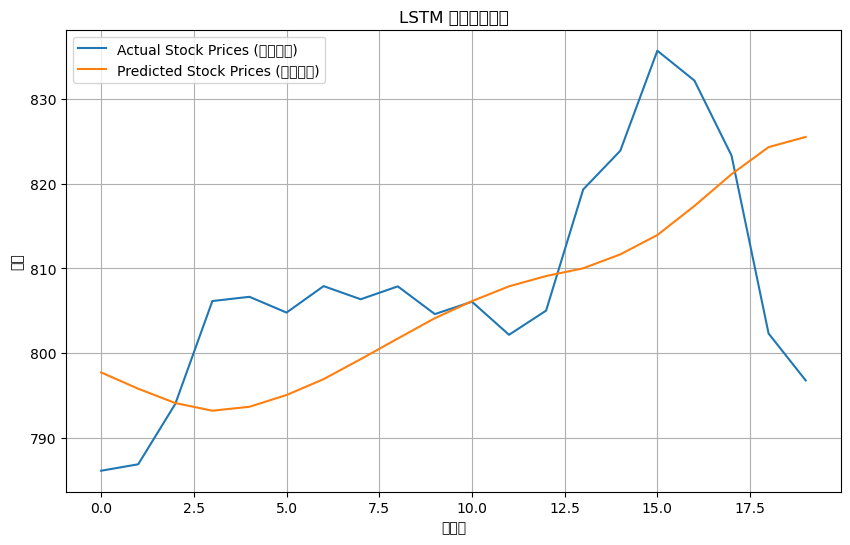

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


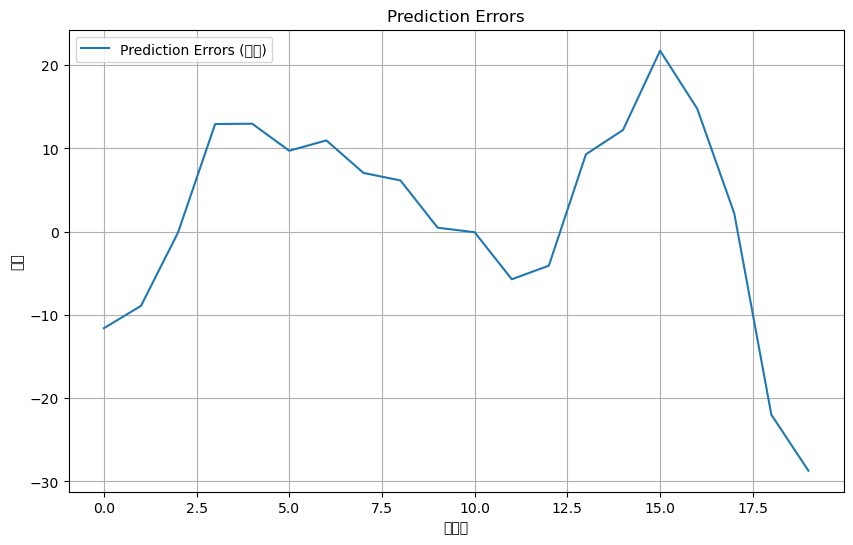

MSE: 157.0377, MAE: 10.0846, RMSE: 12.5315


In [26]:
model = Sequential([
    LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)),
    LSTM(50, activation='tanh', return_sequences=False),
    Dense(1)  # 输出层
])
      

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')  # 学习率调整为 0.0005
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # 增加训练轮数
    batch_size=128,
    verbose=1
)
# 调整测试数据并生成序列（如果需要）
if len(test_close_scaled) <= n_steps:
    test_close_combined = np.concatenate((train_close_scaled[-n_steps:], test_close_scaled), axis=0)
else:
    test_close_combined = test_close_scaled
X_test, y_test = create_sequences(test_close_combined, n_steps)

# 模型预测
predictions = model.predict(X_test)

# 反归一化
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 可视化结果

# 1. 训练和验证损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 2. 真实值与预测值的对比
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Stock Prices (真实价格)')
plt.plot(predictions, label='Predicted Stock Prices (预测价格)')
plt.legend()
plt.title('LSTM 股票价格预测')
plt.xlabel('时间步')
plt.ylabel('价格')
plt.grid()
plt.show()

# 3. 预测误差图
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.plot(errors, label='Prediction Errors (误差)')
plt.title('Prediction Errors')
plt.xlabel('时间步')
plt.ylabel('误差')
plt.legend()
plt.grid()
plt.show()

# 评估模型性能
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")


LSTM improved 3 regu

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1336 - val_loss: 0.0689
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0739 - val_loss: 0.0342
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0431 - val_loss: 0.0086
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0162 - val_loss: 6.2206e-04
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0097 - val_loss: 9.0455e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0093 - val_loss: 5.9767e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0076 - val_loss: 5.8361e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0081 - val_loss: 5.5796e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0065 - val_loss: 6.1446e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0068 - val_loss: 7.2124e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0054 - val_loss: 7.1528e-04
Epoch 12/100
16/16 ━

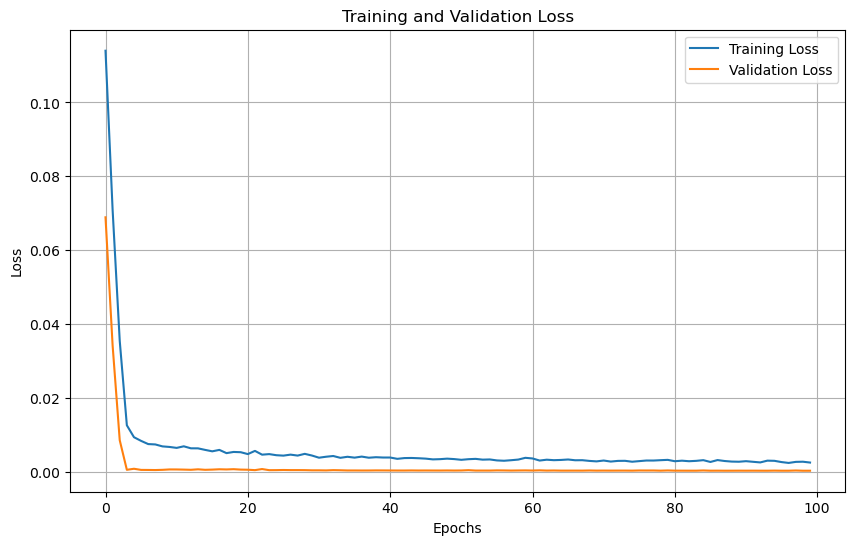

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(b

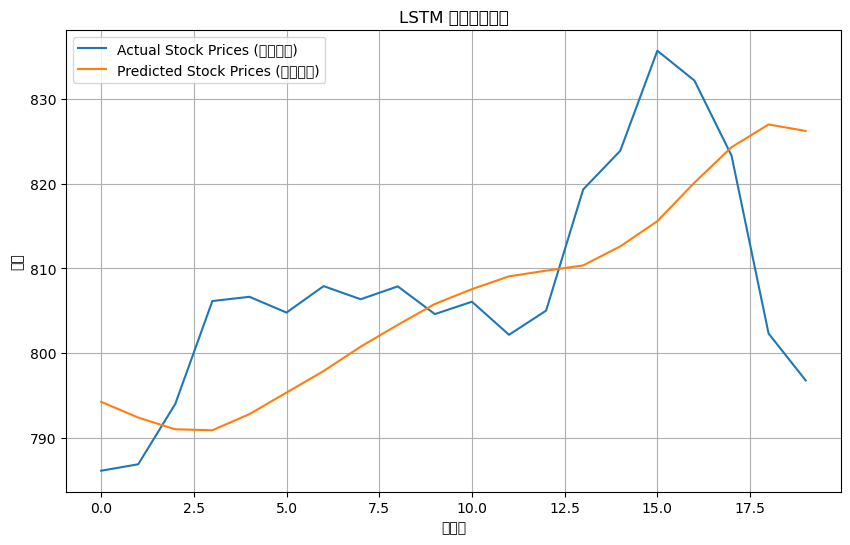

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


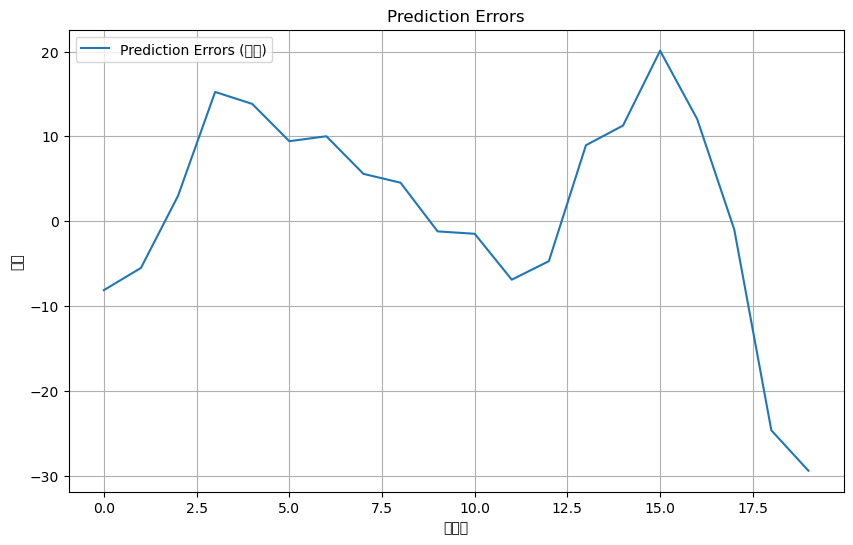

MSE: 153.6887, MAE: 9.8489, RMSE: 12.3971


In [27]:
model = Sequential([
    LSTM(100, activation='tanh', return_sequences=False, input_shape=(n_steps, 1)),
    Dropout(0.2), 
    Dense(1)  # 输出单值（下一天的价格）
])
# 编译模型
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')  
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # 增加训练轮数
    batch_size=64,
    verbose=1
)

# 调整测试数据并生成序列（如果需要）
if len(test_close_scaled) <= n_steps:
    test_close_combined = np.concatenate((train_close_scaled[-n_steps:], test_close_scaled), axis=0)
else:
    test_close_combined = test_close_scaled
X_test, y_test = create_sequences(test_close_combined, n_steps)

# 模型预测
predictions = model.predict(X_test)

# 反归一化
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 可视化结果

# 1. 训练和验证损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 2. 真实值与预测值的对比
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Stock Prices (真实价格)')
plt.plot(predictions, label='Predicted Stock Prices (预测价格)')
plt.legend()
plt.title('LSTM 股票价格预测')
plt.xlabel('时间步')
plt.ylabel('价格')
plt.grid()
plt.show()

# 3. 预测误差图
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.plot(errors, label='Prediction Errors (误差)')
plt.title('Prediction Errors')
plt.xlabel('时间步')
plt.ylabel('误差')
plt.legend()
plt.grid()
plt.show()

# 评估模型性能
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

GRU

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0445 - val_loss: 0.0011
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 3.8639e-04
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - val_loss: 2.8953e-04
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025 - val_loss: 2.6179e-04
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 - val_loss: 2.2134e-04
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 - val_loss: 2.2903e-04
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.1976e-04 - val_loss: 2.4252e-04
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - val_loss: 2.4116e-04
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.9937e-04 - val_loss: 2.2956e-04
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - val_loss: 1.8774e-04
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - val_loss: 1.8330e-04
Epoch 12/20
31/31 ━━━━━━━

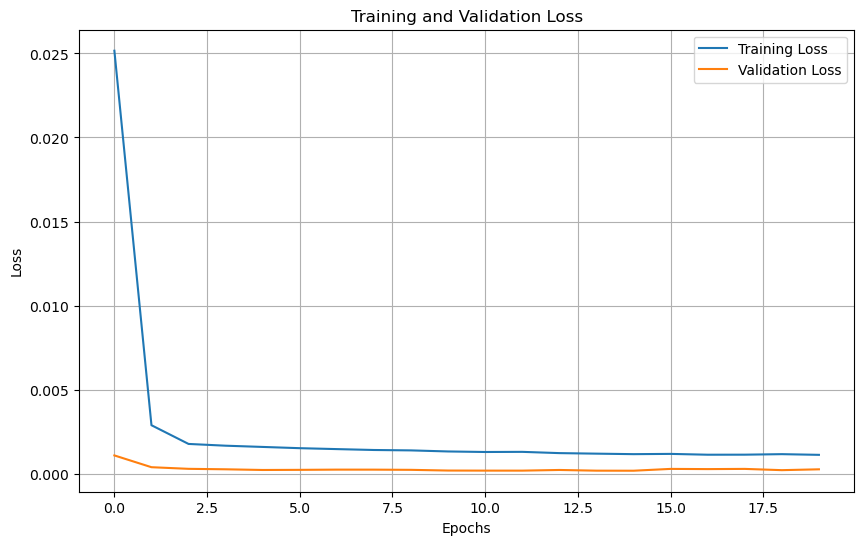

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(b

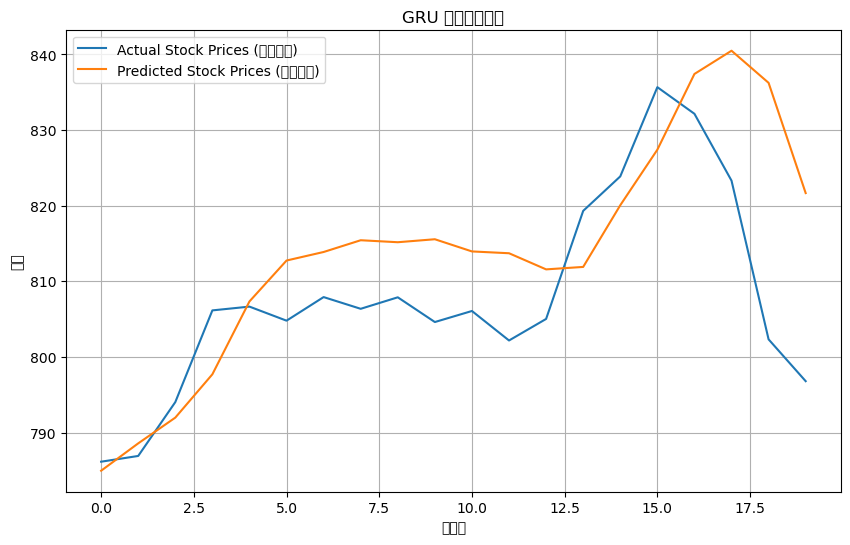

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


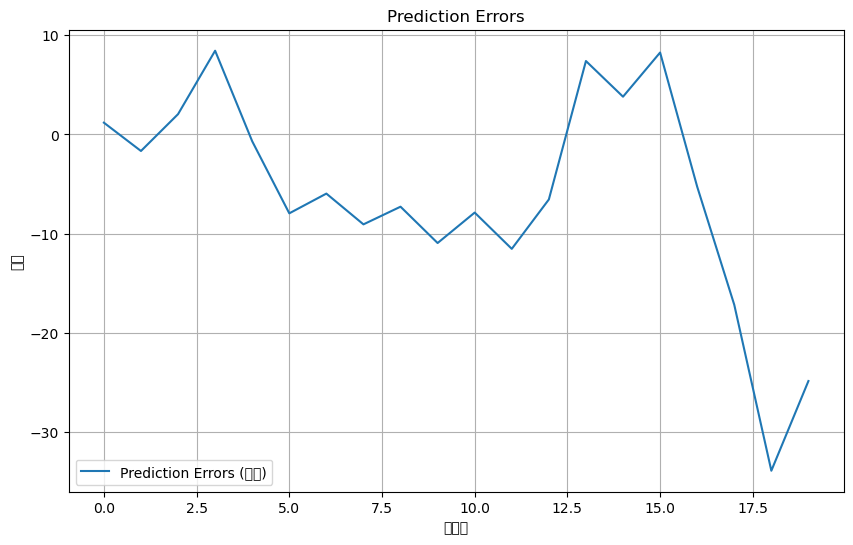

MSE: 145.1176, MAE: 9.0981, RMSE: 12.0465


In [28]:
model = Sequential([
    GRU(50, activation='tanh', return_sequences=False, input_shape=(n_steps, 1)),  # 使用 GRU 单元

    Dense(1)  # 输出单值（下一天的价格）
])

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  # 增加训练轮次
    batch_size=32,
    verbose=1
)
# 调整测试数据并生成序列（如果需要）
if len(test_close_scaled) <= n_steps:
    test_close_combined = np.concatenate((train_close_scaled[-n_steps:], test_close_scaled), axis=0)
else:
    test_close_combined = test_close_scaled
X_test, y_test = create_sequences(test_close_combined, n_steps)

# 模型预测
predictions = model.predict(X_test)

# 反归一化
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 可视化结果

# 1. 训练和验证损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 2. 真实值与预测值的对比
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Stock Prices (真实价格)')
plt.plot(predictions, label='Predicted Stock Prices (预测价格)')
plt.legend()
plt.title('GRU 股票价格预测')
plt.xlabel('时间步')
plt.ylabel('价格')
plt.grid()
plt.show()

# 3. 预测误差图
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.plot(errors, label='Prediction Errors (误差)')
plt.title('Prediction Errors')
plt.xlabel('时间步')
plt.ylabel('误差')
plt.legend()
plt.grid()
plt.show()

# 评估模型性能

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

GRU imrpoved

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8996 - val_loss: 0.7507
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7315 - val_loss: 0.6449
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6288 - val_loss: 0.5583
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5422 - val_loss: 0.4819
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4689 - val_loss: 0.4154
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4039 - val_loss: 0.3573
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3479 - val_loss: 0.3077
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2991 - val_loss: 0.2641
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2579 - val_loss: 0.2270
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2212 - val_loss: 0.1951
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1900 - val_loss: 0.1679
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1645 - val_lo

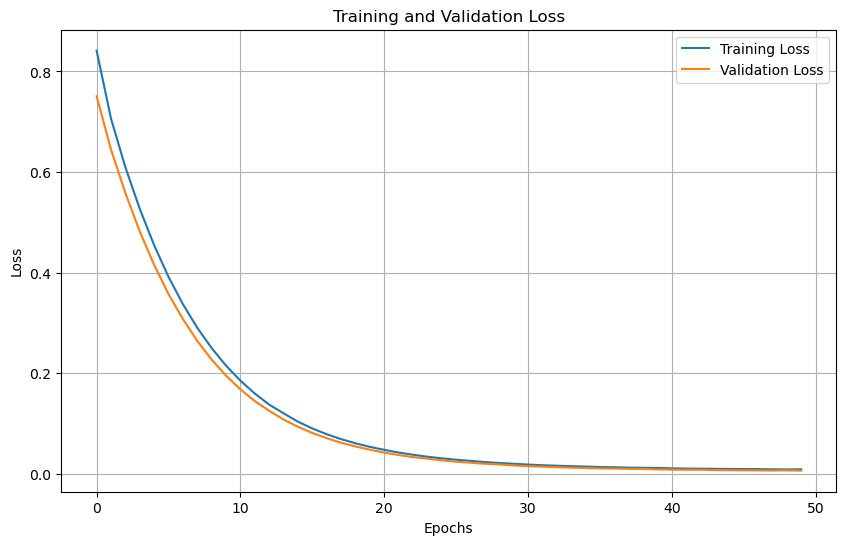

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(b

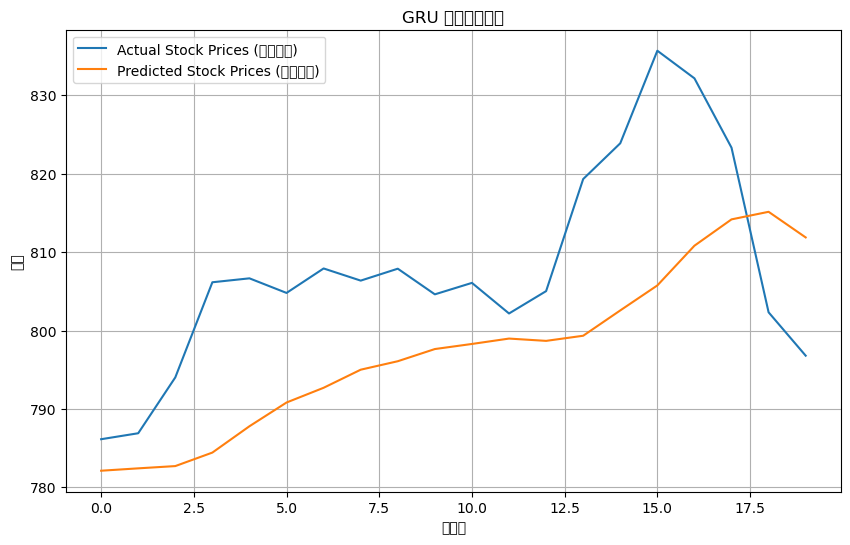

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


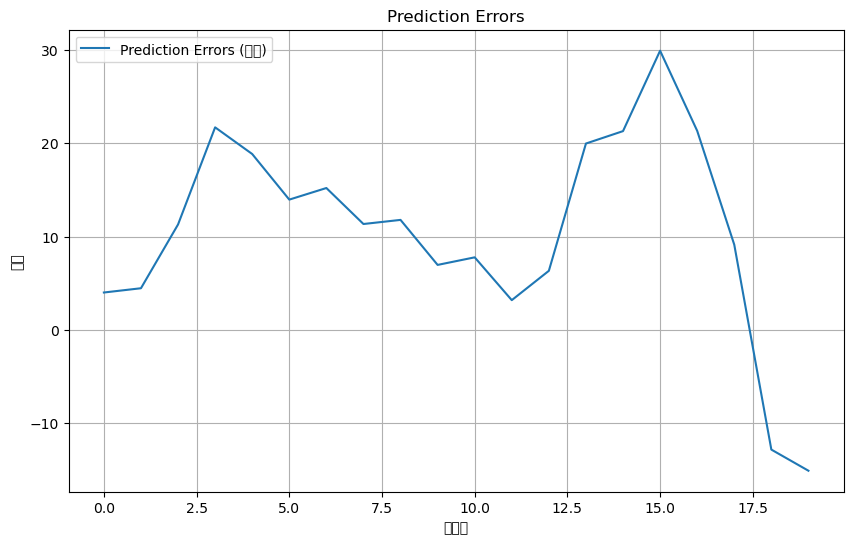

MSE: 226.2355, MAE: 13.3297, RMSE: 15.0411


In [29]:
model = Sequential()

# 添加 L2 正则化的层
model.add(Dense(64, input_dim=30, activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))  # 0.01是L2正则化的强度

model.add(Dense(32, activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))

model.add(Dense(1, activation='linear'))

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # 增加训练轮次
    batch_size=64,
    verbose=1
)
# 调整测试数据并生成序列（如果需要）
if len(test_close_scaled) <= n_steps:
    test_close_combined = np.concatenate((train_close_scaled[-n_steps:], test_close_scaled), axis=0)
else:
    test_close_combined = test_close_scaled
X_test, y_test = create_sequences(test_close_combined, n_steps)

# 模型预测
predictions = model.predict(X_test)

# 反归一化
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 可视化结果

# 1. 训练和验证损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 2. 真实值与预测值的对比
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Stock Prices (真实价格)')
plt.plot(predictions, label='Predicted Stock Prices (预测价格)')
plt.legend()
plt.title('GRU 股票价格预测')
plt.xlabel('时间步')
plt.ylabel('价格')
plt.grid()
plt.show()

# 3. 预测误差图
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.plot(errors, label='Prediction Errors (误差)')
plt.title('Prediction Errors')
plt.xlabel('时间步')
plt.ylabel('误差')
plt.legend()
plt.grid()
plt.show()

# 评估模型性能

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

GRU improved 2

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.3055 - val_loss: 0.7936
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7950 - val_loss: 0.7752
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7690 - val_loss: 0.7042
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6998 - val_loss: 0.6535
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6565 - val_loss: 0.6167
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6179 - val_loss: 0.5798
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5809 - val_loss: 0.5481
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5452 - val_loss: 0.5172
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5190 - val_loss: 0.4890
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4888 - val_loss: 0.4627
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4621 - val_loss: 0.4386
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4379 - val_loss: 0.4158
Epoch 13/100

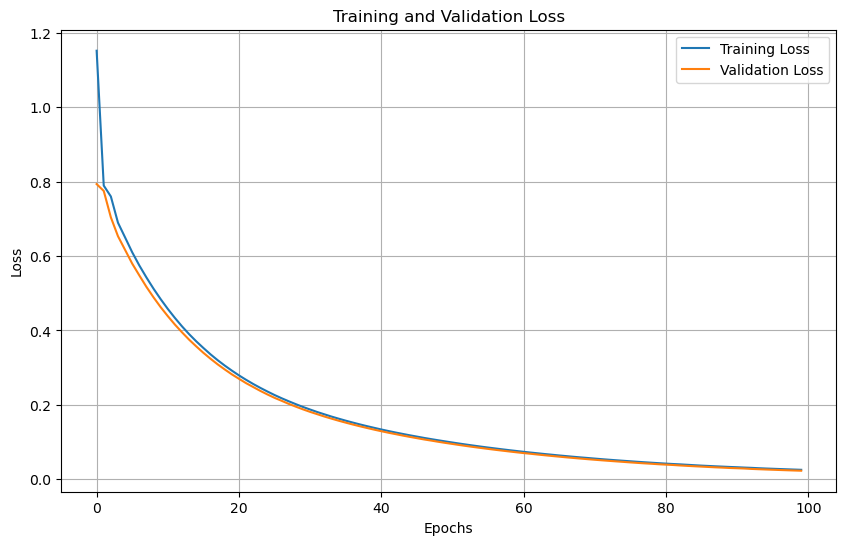

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(b

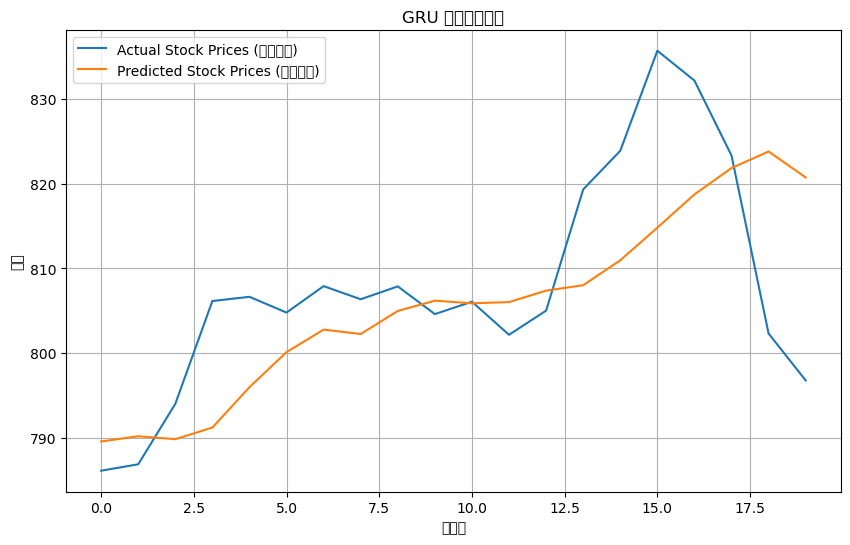

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


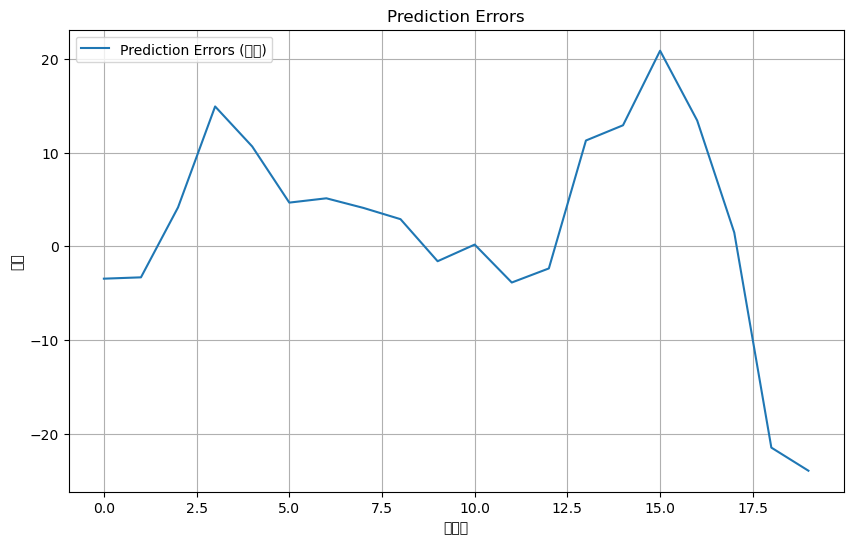

MSE: 120.9230, MAE: 8.3322, RMSE: 10.9965


In [30]:
#构建 GRU 模型
model = Sequential()

# 添加 L2 正则化的层
model.add(Dense(64, input_dim=30, activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))  # 0.01是L2正则化的强度

model.add(Dense(32, activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))

model.add(Dense(1, activation='linear'))

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

#训练模型
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # 增加训练轮次
    batch_size=128,
    verbose=1
)
# 调整测试数据并生成序列（如果需要）
if len(test_close_scaled) <= n_steps:
    test_close_combined = np.concatenate((train_close_scaled[-n_steps:], test_close_scaled), axis=0)
else:
    test_close_combined = test_close_scaled
X_test, y_test = create_sequences(test_close_combined, n_steps)

# 模型预测
predictions = model.predict(X_test)

# 反归一化
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 可视化结果

# 1. 训练和验证损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 2. 真实值与预测值的对比
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Stock Prices (真实价格)')
plt.plot(predictions, label='Predicted Stock Prices (预测价格)')
plt.legend()
plt.title('GRU 股票价格预测')
plt.xlabel('时间步')
plt.ylabel('价格')
plt.grid()
plt.show()

# 3. 预测误差图
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.plot(errors, label='Prediction Errors (误差)')
plt.title('Prediction Errors')
plt.xlabel('时间步')
plt.ylabel('误差')
plt.legend()
plt.grid()
plt.show()

# 评估模型性能

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

GRU imrpoved 3

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.8540 - val_loss: 0.8395
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8493 - val_loss: 0.8349
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8447 - val_loss: 0.8314
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8389 - val_loss: 0.8282
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8364 - val_loss: 0.8248
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8329 - val_loss: 0.8214
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8286 - val_loss: 0.8180
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8239 - val_loss: 0.8146
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8209 - val_loss: 0.8113
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8181 - val_loss: 0.8079
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8140 - val_loss: 0.8045
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8116 - val_loss: 0.8011


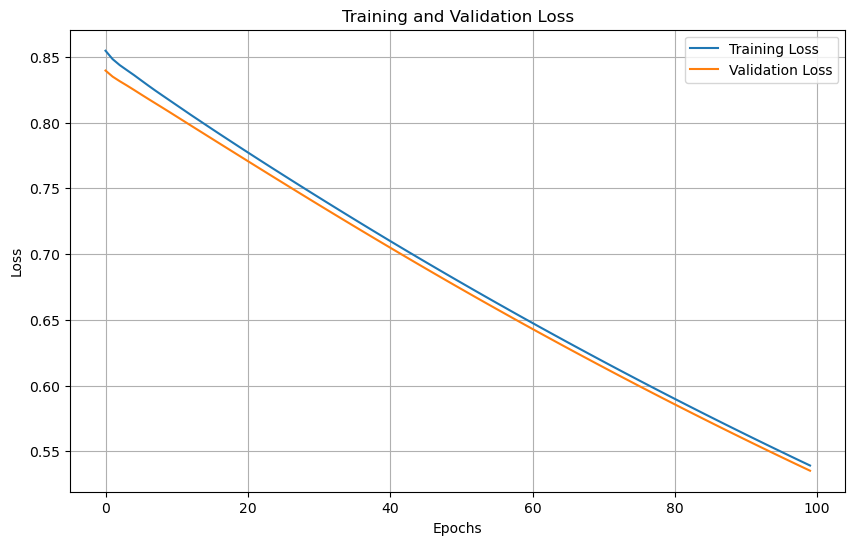

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(b

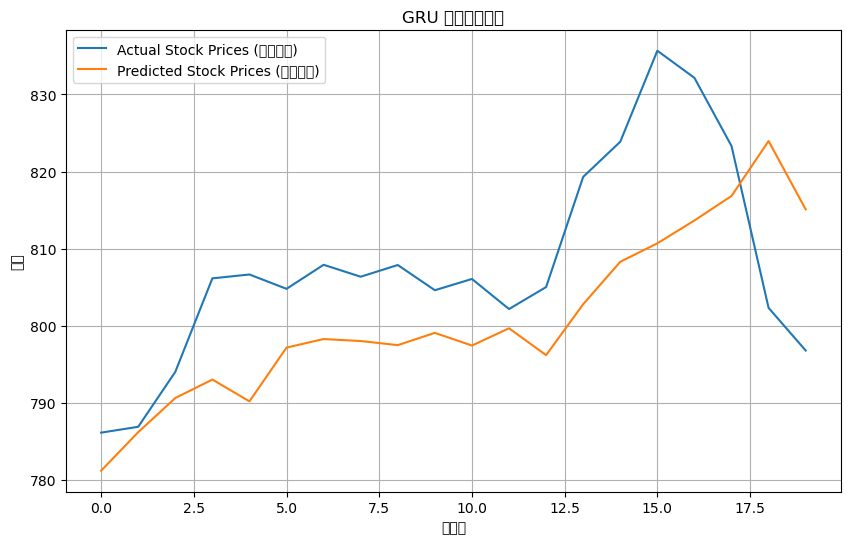

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


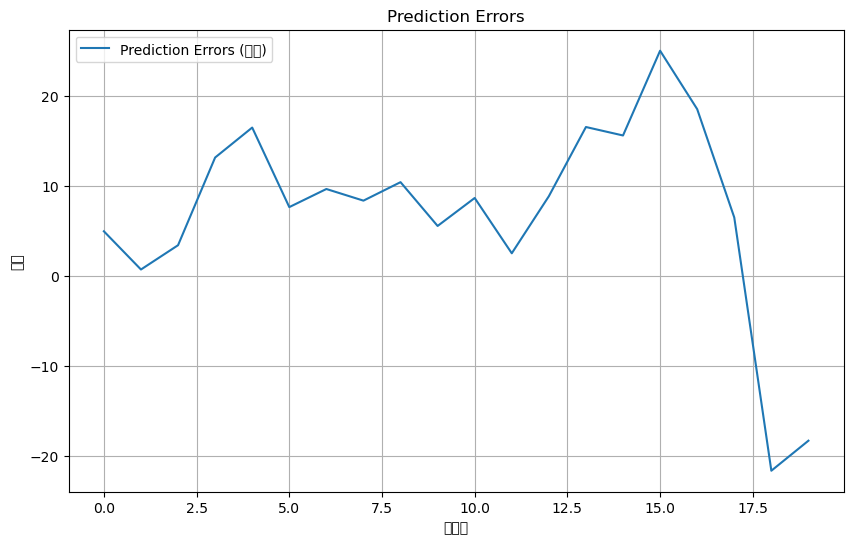

MSE: 166.1543, MAE: 11.1024, RMSE: 12.8901


In [31]:
#构建 GRU 模型
model = Sequential()

# 添加 L2 正则化的层
model.add(Dense(64, input_dim=30, activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))  # 0.01是L2正则化的强度

model.add(Dense(32, activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))

model.add(Dense(1, activation='linear'))

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

#训练模型
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # 增加训练轮次
    batch_size=256,
    verbose=1
)
# 调整测试数据并生成序列（如果需要）
if len(test_close_scaled) <= n_steps:
    test_close_combined = np.concatenate((train_close_scaled[-n_steps:], test_close_scaled), axis=0)
else:
    test_close_combined = test_close_scaled
X_test, y_test = create_sequences(test_close_combined, n_steps)

# 模型预测
predictions = model.predict(X_test)

# 反归一化
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 可视化结果

# 1. 训练和验证损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 2. 真实值与预测值的对比
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Stock Prices (真实价格)')
plt.plot(predictions, label='Predicted Stock Prices (预测价格)')
plt.legend()
plt.title('GRU 股票价格预测')
plt.xlabel('时间步')
plt.ylabel('价格')
plt.grid()
plt.show()

# 3. 预测误差图
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.plot(errors, label='Prediction Errors (误差)')
plt.title('Prediction Errors')
plt.xlabel('时间步')
plt.ylabel('误差')
plt.legend()
plt.grid()
plt.show()

# 评估模型性能

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")